# Live Mouse Tracker Analysis

This notebook is provided by Fabrice Chaumont and Elodie Ey's team, and provides all the basics needed to perform the analysis of the data provided by LiveMouseTracker.

To run this notebook on your computer with Jupyter, proceed as follow:

   - Download [this python repository](https://github.com/fdechaumont/lmt-analysis) and unzip it in a folder on your computer. (note that Jupyter will only let you browse files starting from your home directory. So place this folder in your documents or on your desktop for instance)
   - Install [Anaconda with python v3.x](https://www.anaconda.com/distribution/).
   - And then launch "Jupyter Notebook".
   - Browse to this file on your local computer and then press play. :)


# Main concepts of Live Mouse Tracker:

## Live Mouse Tracker provides two main outputs:

- LiveMouseTracker records data in a database. Those files are .sqlite files. They contains 
    
   - The id of each animal (their RFID number, and also the genotypes of mice if you provide them)
   - All the tracking information (detection, tracks, detection mask of animals )
   - All the events (for instance nose-nose events) with a starting and ending frame.
   - Sensor information (temperature, humidity, light, noise level)
   - Third party events (events generated from an Arduino or a custom TTL device)
    
- Video files, in mp4 format, containing the same view that you had in LiveMouseTracker while performing the record

## Preparing the data

- Events are key in LiveMouseTracker. You will mostly use LMT to check the number of events that occurs during a period, their length, their frequency, how they may be synchronized with other events.
Live Mouse tracker creates a database with a number of events that are computed live, but most of the events are computed in a post processing. To process them, run the following cells. 

In [1]:
import sys
sys.path.insert(1, "../")
from lmtanalysis.FileUtil import getFilesToProcess
import sqlite3
from lmtanalysis.Animal import *
import matplotlib.pyplot as plt
from lmtanalysis.Event import *
from lmtanalysis.Measure import *
from lmtanalysis import BuildEventTrain3, BuildEventTrain4, BuildEventTrain2, BuildEventFollowZone, BuildEventRear5, BuildEventFloorSniffing,\
    BuildEventSocialApproach, BuildEventSocialEscape, BuildEventApproachContact,BuildEventOralOralContact,\
    BuildEventApproachRear, BuildEventGroup2, BuildEventGroup3, BuildEventGroup4, BuildEventOralGenitalContact, \
    BuildEventStop, BuildEventWaterPoint, \
    BuildEventMove, BuildEventGroup3MakeBreak, BuildEventGroup4MakeBreak,\
    BuildEventSideBySide, BuildEventSideBySideOpposite, BuildEventDetection,\
    BuildDataBaseIndex, BuildEventWallJump, BuildEventSAP,\
    BuildEventOralSideSequence, CheckWrongAnimal,\
    CorrectDetectionIntegrity, BuildEventNest4, BuildEventNest3, BuildEventGetAway    
from psutil import virtual_memory
from tkinter.filedialog import askopenfilename
from lmtanalysis.TaskLogger import TaskLogger
import traceback
from lmtanalysis.EventTimeLineCache import flushEventTimeLineCache,\
    disableEventTimeLineCache
from lmtanalysis.EventTimeLineCache import EventTimeLineCached
import pandas as pd
import numpy as np
import time
from datetime import *
import colorsys
from collections import Counter
import seaborn as sns
from lmtanalysis.Util import *
from scripts.InteractionMatrix import *
from dateutil import parser
import math
import os

In [5]:
%run ./rebuild_events.py

Code launched.
Total memory on computer: (GB) 17.095544832
A window is popping (maybe hidden) asking for files to process...
Processing file D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite
D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite
Automatic settings.
Auto max set to 5284010 frames
Creating lmtanalysis indexes...
CREATE INDEX `animalIndex` ON `ANIMAL` (`ID` );
index animalIndex already exists
CREATE INDEX `detectionIndex` ON `DETECTION` (`ID` ASC,`FRAMENUMBER` ASC);
index detectionIndex already exists
CREATE INDEX `detetIdIndex` ON `DETECTION` (`ID` ASC);
index detetIdIndex already exists
CREATE INDEX `detframenumberIndex` ON `DETECTION` (`FRAMENUMBER` ASC);
CREATE INDEX `eventEndFrameIndex` ON `EVENT` (`ENDFRAME` ASC);
CREATE INDEX `eventIndex` ON `EVENT` (`ID` ASC,`STARTFRAME` ASC,`ENDFRAME` ASC);
index eventIndex already exists
CREATE INDEX `eventStartFrameIndex` ON `EVENT` (`STARTFRAME` ASC);
CREATE INDEX `eventstartendIndex` ON `EVENT` (`ST

Number of event deleted: 0 
Deleting event Water Stop (idA:None,idB:None,idC:None,idD:None) from base...
DELETE FROM EVENT WHERE NAME="Water Stop"
Number of event deleted: 0 
[Chrono  Flushing event <module 'lmtanalysis.BuildEventWaterPoint' from '..\\lmtanalysis\\BuildEventWaterPoint.py'>  ]  1.7133872509002686  seconds
Deleting event Approach contact (idA:None,idB:None,idC:None,idD:None) from base...
DELETE FROM EVENT WHERE NAME="Approach contact"
Number of event deleted: 0 
[Chrono  Flushing event <module 'lmtanalysis.BuildEventApproachContact' from '..\\lmtanalysis\\BuildEventApproachContact.py'>  ]  0.8771982192993164  seconds
Deleting event WallJump (idA:None,idB:None,idC:None,idD:None) from base...
DELETE FROM EVENT WHERE NAME="WallJump"
Number of event deleted: 0 
[Chrono  Flushing event <module 'lmtanalysis.BuildEventWallJump' from '..\\lmtanalysis\\BuildEventWallJump.py'>  ]  0.896202802658081  seconds
Deleting event SAP (idA:None,idB:None,idC:None,idD:None) from base...
DELE

Number of event:  5703
Mean length of event:  5.414869366999825
first event frame:  648
Keep previous entry.
Saving timeLine: Oral-oral Contact ( 5703 events )
Oral-oral Contact
Event Oral-oral Contact created. eventNameWithId = Oral-oral Contact idA:2 idB:3 idC:None idD:None loadEvent: False
Number of event:  6448
Mean length of event:  6.122983870967742
first event frame:  125
Keep previous entry.
Saving timeLine: Oral-oral Contact ( 6448 events )
Oral-oral Contact
Event Oral-oral Contact created. eventNameWithId = Oral-oral Contact idA:2 idB:4 idC:None idD:None loadEvent: False
Number of event:  7011
Mean length of event:  6.039366709456568
first event frame:  372
Keep previous entry.
Saving timeLine: Oral-oral Contact ( 7011 events )
Oral-oral Contact
Event Oral-oral Contact created. eventNameWithId = Oral-oral Contact idA:3 idB:1 idC:None idD:None loadEvent: False
Number of event:  4823
Mean length of event:  7.398092473564172
first event frame:  609
Keep previous entry.
Saving ti

Side by side Contact
Event Side by side Contact created. eventNameWithId = Side by side Contact idA:2 idB:4 idC:None idD:None loadEvent: False
Number of event:  8197
Mean length of event:  7.6850067097718675
first event frame:  2113
Keep previous entry.
Saving timeLine: Side by side Contact ( 8197 events )
Side by side Contact
Event Side by side Contact created. eventNameWithId = Side by side Contact idA:3 idB:1 idC:None idD:None loadEvent: False
Number of event:  4685
Mean length of event:  8.03649946638207
first event frame:  7792
Keep previous entry.
Saving timeLine: Side by side Contact ( 4685 events )
Side by side Contact
Event Side by side Contact created. eventNameWithId = Side by side Contact idA:3 idB:2 idC:None idD:None loadEvent: False
Number of event:  6311
Mean length of event:  7.736650293138964
first event frame:  3585
Keep previous entry.
Saving timeLine: Side by side Contact ( 6311 events )
Side by side Contact
Event Side by side Contact created. eventNameWithId = Side

Oral-genital Contact  Id( 3 , 4 , None , None ) Min/maxFrame: ( 0 / 2592000 ) Loaded ( 7608  records loaded in  2.4025418758392334 S )
Caching eventTimeLine
Oral-genital Contact  Id( 4 , 1 , None , None ) Min/maxFrame: ( 0 / 2592000 ) Loaded ( 6912  records loaded in  2.473559617996216 S )
Caching eventTimeLine
Oral-genital Contact  Id( 4 , 2 , None , None ) Min/maxFrame: ( 0 / 2592000 ) Loaded ( 7386  records loaded in  2.3300302028656006 S )
Caching eventTimeLine
Oral-genital Contact  Id( 4 , 3 , None , None ) Min/maxFrame: ( 0 / 2592000 ) Loaded ( 6397  records loaded in  2.463576555252075 S )
Caching eventTimeLine
Train2
Event Train2 created. eventNameWithId = Train2 idA:1 idB:2 idC:None idD:None loadEvent: False
Number of event:  10
Mean length of event:  9.7
first event frame:  10229
Keep previous entry.
Saving timeLine: Train2 ( 10 events )
Train2
Event Train2 created. eventNameWithId = Train2 idA:1 idB:3 idC:None idD:None loadEvent: False
Number of event:  8
Mean length of even

Contact  Id( 3 , None , None , None ) Min/maxFrame: ( 0 / 2592000 ) Loaded ( 8785  records loaded in  2.701622724533081 S )
Caching eventTimeLine
Stop  Id( 4 , None , None , None ) Min/maxFrame: ( 0 / 2592000 ) Loaded ( 38011  records loaded in  3.4732882976531982 S )
Detection  Id( 4 , None , None , None ) Min/maxFrame: ( 0 / 2592000 ) Loaded ( 14632  records loaded in  3.4370572566986084 S )
Contact  Id( 4 , None , None , None ) Min/maxFrame: ( 0 / 2592000 ) Loaded ( 9247  records loaded in  2.947685480117798 S )
Caching eventTimeLine
Event Move created. eventNameWithId = Move idA:1 idB:None idC:None idD:None loadEvent: False
Number of event:  46593
Mean length of event:  4.848410705470779
first event frame:  2
Keep previous entry.
Saving timeLine: Move ( 46593 events )
Event Move isolated created. eventNameWithId = Move isolated idA:1 idB:None idC:None idD:None loadEvent: False
Number of event:  37640
Mean length of event:  4.406296493092455
first event frame:  2
Keep previous entry

A follow B
FollowZone Isolated
Event FollowZone Isolated created. eventNameWithId = FollowZone Isolated idA:1 idB:3 idC:None idD:None loadEvent: False
FollowZone Isolated idA:1 idB:3 idC:None idD:None
Number of event:  1539
Mean length of event:  1.8258609486679662
first event frame:  654
Keep previous entry.
Saving timeLine: FollowZone Isolated ( 1539 events )
A follow B
FollowZone Isolated
Event FollowZone Isolated created. eventNameWithId = FollowZone Isolated idA:2 idB:3 idC:None idD:None loadEvent: False
FollowZone Isolated idA:2 idB:3 idC:None idD:None
Number of event:  2161
Mean length of event:  2.012031466913466
first event frame:  1693
Keep previous entry.
Saving timeLine: FollowZone Isolated ( 2161 events )
A follow B
FollowZone Isolated
Event FollowZone Isolated created. eventNameWithId = FollowZone Isolated idA:4 idB:3 idC:None idD:None loadEvent: False
FollowZone Isolated idA:4 idB:3 idC:None idD:None
Number of event:  1821
Mean length of event:  1.7325645249862713
first 

Social approach
Event Social approach created. eventNameWithId = Social approach idA:2 idB:1 idC:None idD:None loadEvent: False
Number of event:  51952
Mean length of event:  2.379253926701571
first event frame:  66
Keep previous entry.
Saving timeLine: Social approach ( 51952 events )
Social approach
Event Social approach created. eventNameWithId = Social approach idA:2 idB:3 idC:None idD:None loadEvent: False
Number of event:  62202
Mean length of event:  2.277852802160702
first event frame:  122
Keep previous entry.
Saving timeLine: Social approach ( 62202 events )
Social approach
Event Social approach created. eventNameWithId = Social approach idA:2 idB:4 idC:None idD:None loadEvent: False
Number of event:  68371
Mean length of event:  2.206856708253499
first event frame:  66
Keep previous entry.
Saving timeLine: Social approach ( 68371 events )
Social approach
Event Social approach created. eventNameWithId = Social approach idA:3 idB:1 idC:None idD:None loadEvent: False
Number of 

Number of event:  43617
Mean length of event:  2.8186716188642045
first event frame:  6
Keep previous entry.
Saving timeLine: Get away ( 43617 events )
Get away
Event Get away created. eventNameWithId = Get away idA:2 idB:3 idC:None idD:None loadEvent: False
Number of event:  42942
Mean length of event:  2.707465884215919
first event frame:  6
Keep previous entry.
Saving timeLine: Get away ( 42942 events )
Get away
Event Get away created. eventNameWithId = Get away idA:2 idB:4 idC:None idD:None loadEvent: False
Number of event:  43773
Mean length of event:  2.7756379503346813
first event frame:  9
Keep previous entry.
Saving timeLine: Get away ( 43773 events )
Get away
Event Get away created. eventNameWithId = Get away idA:3 idB:1 idC:None idD:None loadEvent: False


Number of event:  49716
Mean length of event:  3.3158540510097354
first event frame:  3
Keep previous entry.
Saving timeLine: Get away ( 49716 events )
Get away
Event Get away created. eventNameWithId = Get away idA:3 idB:2 idC:None idD:None loadEvent: False
Number of event:  50165
Mean length of event:  3.245450014950663
first event frame:  8
Keep previous entry.
Saving timeLine: Get away ( 50165 events )
Get away
Event Get away created. eventNameWithId = Get away idA:3 idB:4 idC:None idD:None loadEvent: False
Number of event:  50349
Mean length of event:  3.2776619197997974
first event frame:  41
Keep previous entry.
Saving timeLine: Get away ( 50349 events )
Get away
Event Get away created. eventNameWithId = Get away idA:4 idB:1 idC:None idD:None loadEvent: False
Number of event:  45881
Mean length of event:  2.679736710185044
first event frame:  33
Keep previous entry.
Saving timeLine: Get away ( 45881 events )
Get away
Event Get away created. eventNameWithId = Get away idA:4 idB:2

Get away  Id( 3 , 2 , None , None ) Min/maxFrame: ( 0 / 2592000 ) Loaded ( 50165  records loaded in  4.713075160980225 S )
Caching eventTimeLine
Get away  Id( 3 , 4 , None , None ) Min/maxFrame: ( 0 / 2592000 ) Loaded ( 50349  records loaded in  4.666064500808716 S )
Caching eventTimeLine
Get away  Id( 4 , 1 , None , None ) Min/maxFrame: ( 0 / 2592000 ) Loaded ( 45881  records loaded in  4.7150657176971436 S )
Caching eventTimeLine
Get away  Id( 4 , 2 , None , None ) Min/maxFrame: ( 0 / 2592000 ) Loaded ( 45842  records loaded in  4.70764422416687 S )
Caching eventTimeLine
Get away  Id( 4 , 3 , None , None ) Min/maxFrame: ( 0 / 2592000 ) Loaded ( 45215  records loaded in  4.5400261878967285 S )
Caching eventTimeLine
mean animal bodysize:  29.308087135879962
mean animal bodysize:  29.12412700623546
mean animal bodysize:  32.116852005862306
mean animal bodysize:  29.341919521284655
Social escape
Event Social escape created. eventNameWithId = Social escape idA:1 idB:2 idC:None idD:None lo

Approach rear
Event Approach rear created. eventNameWithId = Approach rear idA:2 idB:4 idC:None idD:None loadEvent: False
Number of event:  836
Mean length of event:  3.2045454545454546
first event frame:  2688
Keep previous entry.
Saving timeLine: Approach rear ( 836 events )
Approach rear
Event Approach rear created. eventNameWithId = Approach rear idA:3 idB:1 idC:None idD:None loadEvent: False
Number of event:  1002
Mean length of event:  3.129740518962076
first event frame:  596
Keep previous entry.
Saving timeLine: Approach rear ( 1002 events )
Approach rear
Event Approach rear created. eventNameWithId = Approach rear idA:3 idB:2 idC:None idD:None loadEvent: False
Number of event:  1849
Mean length of event:  2.4342888047593294
first event frame:  6696
Keep previous entry.
Saving timeLine: Approach rear ( 1849 events )
Approach rear
Event Approach rear created. eventNameWithId = Approach rear idA:3 idB:4 idC:None idD:None loadEvent: False
Number of event:  728
Mean length of event

Number of event:  2166
Mean length of event:  23.709141274238227
first event frame:  125
Keep previous entry.
Saving timeLine: Group3 ( 2166 events )
Group3
Event Group3 created. eventNameWithId = Group3 idA:1 idB:2 idC:4 idD:None loadEvent: False
Number of event:  2376
Mean length of event:  31.983164983164983
first event frame:  441
Keep previous entry.
Saving timeLine: Group3 ( 2376 events )
Group3
Event Group3 created. eventNameWithId = Group3 idA:1 idB:3 idC:2 idD:None loadEvent: False
Number of event:  2166
Mean length of event:  23.709141274238227
first event frame:  125
Keep previous entry.
Saving timeLine: Group3 ( 2166 events )
Group3
Event Group3 created. eventNameWithId = Group3 idA:1 idB:3 idC:4 idD:None loadEvent: False
Number of event:  2733
Mean length of event:  24.666666666666668
first event frame:  8291
Keep previous entry.
Saving timeLine: Group3 ( 2733 events )
Group3
Event Group3 created. eventNameWithId = Group3 idA:1 idB:4 idC:2 idD:None loadEvent: False
Number 

Group4
Event Group4 created. eventNameWithId = Group4 idA:2 idB:3 idC:4 idD:1 loadEvent: False
Group4
Event Group4 created. eventNameWithId = Group4 idA:2 idB:4 idC:1 idD:3 loadEvent: False
Group4
Event Group4 created. eventNameWithId = Group4 idA:2 idB:4 idC:3 idD:1 loadEvent: False
Group4
Event Group4 created. eventNameWithId = Group4 idA:3 idB:1 idC:2 idD:4 loadEvent: False
Group4
Event Group4 created. eventNameWithId = Group4 idA:3 idB:1 idC:4 idD:2 loadEvent: False
Group4
Event Group4 created. eventNameWithId = Group4 idA:3 idB:2 idC:1 idD:4 loadEvent: False
Group4
Event Group4 created. eventNameWithId = Group4 idA:3 idB:2 idC:4 idD:1 loadEvent: False
Group4
Event Group4 created. eventNameWithId = Group4 idA:3 idB:4 idC:1 idD:2 loadEvent: False
Group4
Event Group4 created. eventNameWithId = Group4 idA:3 idB:4 idC:2 idD:1 loadEvent: False
Group4
Event Group4 created. eventNameWithId = Group4 idA:4 idB:1 idC:2 idD:3 loadEvent: False
Group4
Event Group4 created. eventNameWithId = Gro

Group4  Id( 1 , 2 , 3 , None ) Min/maxFrame: ( 0 / 2592000 ) Loaded ( 0  records loaded in  4.688563108444214 S )
Caching eventTimeLine
Group4  Id( 1 , 2 , 4 , None ) Min/maxFrame: ( 0 / 2592000 ) Loaded ( 0  records loaded in  4.733146667480469 S )
Caching eventTimeLine
Group4  Id( 1 , 3 , 2 , None ) Min/maxFrame: ( 0 / 2592000 ) Loaded ( 0  records loaded in  4.740070343017578 S )
Caching eventTimeLine
Group4  Id( 1 , 3 , 4 , None ) Min/maxFrame: ( 0 / 2592000 ) Loaded ( 0  records loaded in  4.702295780181885 S )
Caching eventTimeLine
Group4  Id( 1 , 4 , 2 , None ) Min/maxFrame: ( 0 / 2592000 ) Loaded ( 0  records loaded in  4.708077907562256 S )
Caching eventTimeLine
Group4  Id( 1 , 4 , 3 , None ) Min/maxFrame: ( 0 / 2592000 ) Loaded ( 0  records loaded in  4.75508451461792 S )
Caching eventTimeLine
Group4  Id( 2 , 1 , 3 , None ) Min/maxFrame: ( 0 / 2592000 ) Loaded ( 0  records loaded in  4.766580104827881 S )
Caching eventTimeLine
Group4  Id( 2 , 1 , 4 , None ) Min/maxFrame: ( 0 

INSERT INTO LOG( process,version,date,tmin,tmax) VALUES ( 'Build Event Stop','0','2020-07-21 15:41:25','0','2592000' );
Rebuild event finished.
[Chrono  <module 'lmtanalysis.BuildEventStop' from '..\\lmtanalysis\\BuildEventStop.py'>  ]  412.16999650001526  seconds
Animal Id:1 Name:A RFID:000022986387 Genotype:None User1:None
A is in the zone around the water source
Water Zone
Event Water Zone created. eventNameWithId = Water Zone idA:1 idB:None idC:None idD:None loadEvent: False
Event Water Stop created. eventNameWithId = Water Stop idA:1 idB:None idC:None idD:None loadEvent: False
Stop  Id( 1 , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 71979  records loaded in  32.11522030830383 S )
Caching eventTimeLine
Number of event:  2440
Mean length of event:  14.115573770491803
first event frame:  18401
Keep previous entry.
Saving timeLine: Water Zone ( 2440 events )
no event
Keep previous entry.
Saving timeLine: Water Stop ( 0 events )
Animal Id:2 Name:B RFID:000022986392 Gen

Approach contact
Event Approach contact created. eventNameWithId = Approach contact idA:4 idB:3 idC:None idD:None loadEvent: False
Number of event:  40041
Mean length of event:  2.249868884393497
first event frame:  190
Keep previous entry.
Saving timeLine: Approach contact ( 40041 events )
INSERT INTO LOG( process,version,date,tmin,tmax) VALUES ( 'Build Event Approach Contact','0','2020-07-21 15:53:22','0','2592000' );
Rebuild event finished.
[Chrono  <module 'lmtanalysis.BuildEventApproachContact' from '..\\lmtanalysis\\BuildEventApproachContact.py'>  ]  621.4493410587311  seconds
Animal Id:1 Name:A RFID:000022986387 Genotype:None User1:None
A is jumping against the wall
WallJump
Event WallJump created. eventNameWithId = WallJump idA:1 idB:None idC:None idD:None loadEvent: False
Number of event:  1302
Mean length of event:  2.3287250384024576
first event frame:  1311
Keep previous entry.
Saving timeLine: WallJump ( 1302 events )
Animal Id:2 Name:B RFID:000022986392 Genotype:None User

Event seq oral oral - oral genital created. eventNameWithId = seq oral oral - oral genital idA:2 idB:3 idC:None idD:None loadEvent: False
seq oral oral - oral genital idA:2 idB:3 idC:None idD:None
Number of event:  315
Mean length of event:  54.36190476190476
first event frame:  3580
Keep previous entry.
Saving timeLine: seq oral oral - oral genital ( 315 events )
Event seq oral oral - oral genital created. eventNameWithId = seq oral oral - oral genital idA:2 idB:4 idC:None idD:None loadEvent: False
seq oral oral - oral genital idA:2 idB:4 idC:None idD:None
Number of event:  372
Mean length of event:  59.395161290322584
first event frame:  5172
Keep previous entry.
Saving timeLine: seq oral oral - oral genital ( 372 events )
Event seq oral oral - oral genital created. eventNameWithId = seq oral oral - oral genital idA:3 idB:1 idC:None idD:None loadEvent: False
seq oral oral - oral genital idA:3 idB:1 idC:None idD:None
Number of event:  254
Mean length of event:  55.55511811023622
first

Stop  Id( None , None , None , None ) Min/maxFrame: ( 0 / 2592000 ) Loaded ( 13123  records loaded in  7.71925950050354 S )
Caching eventTimeLine
Stop  Id( None , None , None , None ) Loaded from cache ( 13123  records. )
Stop  Id( None , None , None , None ) Loaded from cache ( 13123  records. )
Stop  Id( None , None , None , None ) Loaded from cache ( 13123  records. )
Event Nest3_ created. eventNameWithId = Nest3_ idA:1 idB:None idC:None idD:None loadEvent: False
Event Nest3_ created. eventNameWithId = Nest3_ idA:2 idB:None idC:None idD:None loadEvent: False
Event Nest3_ created. eventNameWithId = Nest3_ idA:3 idB:None idC:None idD:None loadEvent: False
Event Nest3_ created. eventNameWithId = Nest3_ idA:4 idB:None idC:None idD:None loadEvent: False
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID IS NULL
863398  frames containing anonymous detections loaded in 47.70615792274475 seconds.
Number of event:  2478
Mean length of event:  57.3228410008071
first event frame:

 detections loaded in 44.18724489212036 seconds.
Number of event:  18221
Mean length of event:  78.80714560122935
first event frame:  2592000
Keep previous entry.
Saving timeLine: Detection ( 18221 events )
Detection
Event Detection created. eventNameWithId = Detection idA:2 idB:None idC:None idD:None loadEvent: False
processing animal ID: 2
SELECT FRAMENUMBER FROM DETECTION WHERE ANIMALID=2 AND FRAMENUMBER>=2592000 AND FRAMENUMBER<=5184000
 detections loaded in 49.5063099861145 seconds.
Number of event:  18193
Mean length of event:  86.61012477326445
first event frame:  2592000
Keep previous entry.
Saving timeLine: Detection ( 18193 events )
Detection
Event Detection created. eventNameWithId = Detection idA:3 idB:None idC:None idD:None loadEvent: False
processing animal ID: 3
SELECT FRAMENUMBER FROM DETECTION WHERE ANIMALID=3 AND FRAMENUMBER>=2592000 AND FRAMENUMBER<=5184000
 detections loaded in 47.038294076919556 seconds.
Number of event:  17219
Mean length of event:  91.81990824089

Oral-genital Contact
Event Oral-genital Contact created. eventNameWithId = Oral-genital Contact idA:1 idB:4 idC:None idD:None loadEvent: False
Number of event:  7175
Mean length of event:  5.266062717770035
first event frame:  2592577
Keep previous entry.
Saving timeLine: Oral-genital Contact ( 7175 events )
Oral-genital Contact
Event Oral-genital Contact created. eventNameWithId = Oral-genital Contact idA:2 idB:1 idC:None idD:None loadEvent: False
Number of event:  6531
Mean length of event:  5.415097228602051
first event frame:  2595183
Keep previous entry.
Saving timeLine: Oral-genital Contact ( 6531 events )
Oral-genital Contact
Event Oral-genital Contact created. eventNameWithId = Oral-genital Contact idA:2 idB:3 idC:None idD:None loadEvent: False
Number of event:  7341
Mean length of event:  5.714207873586705
first event frame:  2592671
Keep previous entry.
Saving timeLine: Oral-genital Contact ( 7341 events )
Oral-genital Contact
Event Oral-genital Contact created. eventNameWith

Number of event:  6945
Mean length of event:  7.59812814974802
first event frame:  2592638
Keep previous entry.
Saving timeLine: Side by side Contact, opposite way ( 6945 events )
Side by side Contact, opposite way
Event Side by side Contact, opposite way created. eventNameWithId = Side by side Contact, opposite way idA:2 idB:1 idC:None idD:None loadEvent: False
Number of event:  6701
Mean length of event:  7.209520967019848
first event frame:  2592591
Keep previous entry.
Saving timeLine: Side by side Contact, opposite way ( 6701 events )
Side by side Contact, opposite way
Event Side by side Contact, opposite way created. eventNameWithId = Side by side Contact, opposite way idA:2 idB:3 idC:None idD:None loadEvent: False
Number of event:  6354
Mean length of event:  8.010701920050362
first event frame:  2592683
Keep previous entry.
Saving timeLine: Side by side Contact, opposite way ( 6354 events )
Side by side Contact, opposite way
Event Side by side Contact, opposite way created. eve

Train2
Event Train2 created. eventNameWithId = Train2 idA:4 idB:3 idC:None idD:None loadEvent: False
Number of event:  2
Mean length of event:  5.5
first event frame:  4107976
Keep previous entry.
Saving timeLine: Train2 ( 2 events )
INSERT INTO LOG( process,version,date,tmin,tmax) VALUES ( 'Build Event Train2','0','2020-07-21 16:42:49','2592000','5184000' );
Rebuild event finished.
[Chrono  <module 'lmtanalysis.BuildEventTrain2' from '..\\lmtanalysis\\BuildEventTrain2.py'>  ]  506.376273393631  seconds
Train2  Id( 1 , 2 , None , None ) Min/maxFrame: ( 2592000 / 5184000 ) Loaded ( 5  records loaded in  8.399402856826782 S )
Caching eventTimeLine
Train2  Id( 1 , 3 , None , None ) Min/maxFrame: ( 2592000 / 5184000 ) Loaded ( 2  records loaded in  8.428904294967651 S )
Caching eventTimeLine
Train2  Id( 1 , 4 , None , None ) Min/maxFrame: ( 2592000 / 5184000 ) Loaded ( 4  records loaded in  8.327881574630737 S )
Caching eventTimeLine
Train2  Id( 2 , 1 , None , None ) Min/maxFrame: ( 259200

Event Move isolated created. eventNameWithId = Move isolated idA:4 idB:None idC:None idD:None loadEvent: False
Number of event:  27601
Mean length of event:  4.841998478316003
first event frame:  2592741
Keep previous entry.
Saving timeLine: Move isolated ( 27601 events )
Event Move in contact created. eventNameWithId = Move in contact idA:4 idB:None idC:None idD:None loadEvent: False
Number of event:  13629
Mean length of event:  4.264656247707095
first event frame:  2592001
Keep previous entry.
Saving timeLine: Move in contact ( 13629 events )
INSERT INTO LOG( process,version,date,tmin,tmax) VALUES ( 'Build Event Move','0','2020-07-21 16:52:40','2592000','5184000' );
Rebuild event finished.
[Chrono  <module 'lmtanalysis.BuildEventMove' from '..\\lmtanalysis\\BuildEventMove.py'>  ]  489.85311460494995  seconds
Animal Id:1 Name:A RFID:000022986387 Genotype:None User1:None
mean animal bodysize:  26.893017290368288
Contact  Id( 2 , 1 , None , None ) Min/maxFrame: ( 2592000 / 5184000 ) Lo

Number of event:  4208
Mean length of event:  2.747861216730038
first event frame:  2593108
Keep previous entry.
Saving timeLine: Rear isolated ( 4208 events )
Animal Id:2 Name:B RFID:000022986392 Genotype:None User1:None
Contact  Id( 2 , None , None , None ) Loaded from cache ( 9233  records. )
A rears
Event Rear in contact created. eventNameWithId = Rear in contact idA:2 idB:None idC:None idD:None loadEvent: False
Event Rear isolated created. eventNameWithId = Rear isolated idA:2 idB:None idC:None idD:None loadEvent: False
Number of event:  1516
Mean length of event:  2.5395778364116093
first event frame:  2597379
Keep previous entry.
Saving timeLine: Rear in contact ( 1516 events )
Number of event:  2352
Mean length of event:  5.286139455782313
first event frame:  2605055
Keep previous entry.
Saving timeLine: Rear isolated ( 2352 events )
Animal Id:3 Name:C RFID:000022986491 Genotype:None User1:None
Contact  Id( 3 , None , None , None ) Loaded from cache ( 7964  records. )
A rears
E

Number of event:  32117
Mean length of event:  2.3146620170003427
first event frame:  2592001
Keep previous entry.
Saving timeLine: Get away ( 32117 events )
Get away
Event Get away created. eventNameWithId = Get away idA:1 idB:3 idC:None idD:None loadEvent: False
Number of event:  32230
Mean length of event:  2.253242320819113
first event frame:  2592036
Keep previous entry.
Saving timeLine: Get away ( 32230 events )
Get away
Event Get away created. eventNameWithId = Get away idA:1 idB:4 idC:None idD:None loadEvent: False
Number of event:  32323
Mean length of event:  2.301147789499737
first event frame:  2592001
Keep previous entry.
Saving timeLine: Get away ( 32323 events )
Get away
Event Get away created. eventNameWithId = Get away idA:2 idB:1 idC:None idD:None loadEvent: False
Number of event:  33781
Mean length of event:  2.2827921020692106
first event frame:  2592106
Keep previous entry.
Saving timeLine: Get away ( 33781 events )
Get away
Event Get away created. eventNameWithId 

Number of event:  36210
Mean length of event:  3.0046119856393263
first event frame:  2592092
Keep previous entry.
Saving timeLine: Get away ( 36210 events )
Get away
Event Get away created. eventNameWithId = Get away idA:3 idB:2 idC:None idD:None loadEvent: False
Number of event:  37841
Mean length of event:  3.0025105044792686
first event frame:  2592092
Keep previous entry.
Saving timeLine: Get away ( 37841 events )
Get away
Event Get away created. eventNameWithId = Get away idA:3 idB:4 idC:None idD:None loadEvent: False
Number of event:  36896
Mean length of event:  2.990622289679098
first event frame:  2592092
Keep previous entry.
Saving timeLine: Get away ( 36896 events )
Get away
Event Get away created. eventNameWithId = Get away idA:4 idB:1 idC:None idD:None loadEvent: False
Number of event:  37483
Mean length of event:  2.497158711949417
first event frame:  2592108
Keep previous entry.
Saving timeLine: Get away ( 37483 events )
Get away
Event Get away created. eventNameWithId 

Number of event:  38128
Mean length of event:  2.4864141838019305
first event frame:  2592152
Keep previous entry.
Saving timeLine: Get away ( 38128 events )
INSERT INTO LOG( process,version,date,tmin,tmax) VALUES ( 'Build Event Get Away','0','2020-07-21 17:16:43','2592000','5184000' );
Rebuild event finished.
[Chrono  <module 'lmtanalysis.BuildEventGetAway' from '..\\lmtanalysis\\BuildEventGetAway.py'>  ]  622.264261007309  seconds
STARTING SOCIAL ESCAPE
Get away  Id( 1 , 2 , None , None ) Min/maxFrame: ( 2592000 / 5184000 ) Loaded ( 32117  records loaded in  10.051282167434692 S )
Caching eventTimeLine
Get away  Id( 1 , 3 , None , None ) Min/maxFrame: ( 2592000 / 5184000 ) Loaded ( 32230  records loaded in  9.909876108169556 S )
Caching eventTimeLine
Get away  Id( 1 , 4 , None , None ) Min/maxFrame: ( 2592000 / 5184000 ) Loaded ( 32323  records loaded in  9.875153064727783 S )
Caching eventTimeLine
Get away  Id( 2 , 1 , None , None ) Min/maxFrame: ( 2592000 / 5184000 ) Loaded ( 33781

Social approach  Id( 4 , 2 , None , None ) Min/maxFrame: ( 2592000 / 5184000 ) Loaded ( 61513  records loaded in  10.4163818359375 S )
Caching eventTimeLine
Social approach  Id( 4 , 3 , None , None ) Min/maxFrame: ( 2592000 / 5184000 ) Loaded ( 55069  records loaded in  10.353353023529053 S )
Caching eventTimeLine
Approach rear
Event Approach rear created. eventNameWithId = Approach rear idA:1 idB:2 idC:None idD:None loadEvent: False
Number of event:  1166
Mean length of event:  2.486277873070326
first event frame:  2597369
Keep previous entry.
Saving timeLine: Approach rear ( 1166 events )
Approach rear
Event Approach rear created. eventNameWithId = Approach rear idA:1 idB:3 idC:None idD:None loadEvent: False
Number of event:  1555
Mean length of event:  2.639871382636656
first event frame:  2597158
Keep previous entry.
Saving timeLine: Approach rear ( 1555 events )
Approach rear
Event Approach rear created. eventNameWithId = Approach rear idA:1 idB:4 idC:None idD:None loadEvent: Fals

Group2
Event Group2 created. eventNameWithId = Group2 idA:3 idB:4 idC:None idD:None loadEvent: False
Number of event:  2777
Mean length of event:  21.753330932661147
first event frame:  2602122
Keep previous entry.
Saving timeLine: Group2 ( 2777 events )
Group2
Event Group2 created. eventNameWithId = Group2 idA:4 idB:1 idC:None idD:None loadEvent: False
Group2
Event Group2 created. eventNameWithId = Group2 idA:4 idB:1 idC:None idD:None loadEvent: False
Number of event:  2638
Mean length of event:  36.143290371493556
first event frame:  2592749
Keep previous entry.
Saving timeLine: Group2 ( 2638 events )
Group2
Event Group2 created. eventNameWithId = Group2 idA:4 idB:2 idC:None idD:None loadEvent: False
Group2
Event Group2 created. eventNameWithId = Group2 idA:4 idB:2 idC:None idD:None loadEvent: False
Number of event:  3434
Mean length of event:  31.146476412347116
first event frame:  2592000
Keep previous entry.
Saving timeLine: Group2 ( 3434 events )
Group2
Event Group2 created. even

Number of event:  2146
Mean length of event:  33.914725069897486
first event frame:  2592677
Keep previous entry.
Saving timeLine: Group3 ( 2146 events )
Group3
Event Group3 created. eventNameWithId = Group3 idA:4 idB:3 idC:1 idD:None loadEvent: False
Number of event:  1898
Mean length of event:  32.104847207586936
first event frame:  2619319
Keep previous entry.
Saving timeLine: Group3 ( 1898 events )
Group3
Event Group3 created. eventNameWithId = Group3 idA:4 idB:3 idC:2 idD:None loadEvent: False
Number of event:  2146
Mean length of event:  33.914725069897486
first event frame:  2592677
Keep previous entry.
Saving timeLine: Group3 ( 2146 events )
INSERT INTO LOG( process,version,date,tmin,tmax) VALUES ( 'Build Event Group 3','0','2020-07-21 17:37:03','2592000','5184000' );
Rebuild event finished.
[Chrono  <module 'lmtanalysis.BuildEventGroup3' from '..\\lmtanalysis\\BuildEventGroup3.py'>  ]  292.23636627197266  seconds
Loading animals.
Fields available in lmtanalysis:  ['ID', 'RFID'

Group3  Id( 3 , 1 , 2 , None ) Min/maxFrame: ( 2592000 / 5184000 ) Loaded ( 2078  records loaded in  10.170841693878174 S )
Caching eventTimeLine
Group3  Id( 3 , 1 , 4 , None ) Min/maxFrame: ( 2592000 / 5184000 ) Loaded ( 1898  records loaded in  10.170825481414795 S )
Caching eventTimeLine
Group3  Id( 3 , 2 , 1 , None ) Min/maxFrame: ( 2592000 / 5184000 ) Loaded ( 2078  records loaded in  10.132803916931152 S )
Caching eventTimeLine
Group3  Id( 3 , 2 , 4 , None ) Min/maxFrame: ( 2592000 / 5184000 ) Loaded ( 2146  records loaded in  10.135982751846313 S )
Caching eventTimeLine
Group3  Id( 3 , 4 , 1 , None ) Min/maxFrame: ( 2592000 / 5184000 ) Loaded ( 1898  records loaded in  10.169246435165405 S )
Caching eventTimeLine
Group3  Id( 3 , 4 , 2 , None ) Min/maxFrame: ( 2592000 / 5184000 ) Loaded ( 2146  records loaded in  10.156166315078735 S )
Caching eventTimeLine
Group3  Id( 4 , 1 , 2 , None ) Min/maxFrame: ( 2592000 / 5184000 ) Loaded ( 2188  records loaded in  10.240182161331177 S )


Number of event:  720
Mean length of event:  1.0
first event frame:  2635771
Keep previous entry.
Saving timeLine: Group 4 make ( 720 events )
Number of event:  740
Mean length of event:  1.0
first event frame:  2592677
Keep previous entry.
Saving timeLine: Group 4 break ( 740 events )
Number of event:  446
Mean length of event:  1.0
first event frame:  2629105
Keep previous entry.
Saving timeLine: Group 4 make ( 446 events )
Number of event:  473
Mean length of event:  1.0
first event frame:  2629117
Keep previous entry.
Saving timeLine: Group 4 break ( 473 events )
Number of event:  545
Mean length of event:  1.0
first event frame:  2592654
Keep previous entry.
Saving timeLine: Group 4 make ( 545 events )
Number of event:  539
Mean length of event:  1.0
first event frame:  2622657
Keep previous entry.
Saving timeLine: Group 4 break ( 539 events )
Number of event:  394
Mean length of event:  1.0
first event frame:  2622158
Keep previous entry.
Saving timeLine: Group 4 make ( 394 event

Social approach  Id( 1 , 3 , None , None ) Loaded from cache ( 45162  records. )
Contact  Id( 1 , 4 , None , None ) Loaded from cache ( 7267  records. )
Social approach  Id( 1 , 4 , None , None ) Loaded from cache ( 52921  records. )
Contact  Id( 2 , 1 , None , None ) Loaded from cache ( 9661  records. )
Social approach  Id( 2 , 1 , None , None ) Loaded from cache ( 51755  records. )
Contact  Id( 2 , 3 , None , None ) Loaded from cache ( 9014  records. )
Social approach  Id( 2 , 3 , None , None ) Loaded from cache ( 59591  records. )
Contact  Id( 2 , 4 , None , None ) Loaded from cache ( 9519  records. )
Social approach  Id( 2 , 4 , None , None ) Loaded from cache ( 61854  records. )
Contact  Id( 3 , 1 , None , None ) Loaded from cache ( 8529  records. )
Social approach  Id( 3 , 1 , None , None ) Loaded from cache ( 46319  records. )
Contact  Id( 3 , 2 , None , None ) Loaded from cache ( 9014  records. )
Social approach  Id( 3 , 2 , None , None ) Loaded from cache ( 57151  records. )
C

mean animal bodysize:  26.893017290368288
Oral-oral Contact  Id( 2 , 1 , None , None ) Min/maxFrame: ( 2592000 / 5184000 ) Loaded ( 5481  records loaded in  10.804286479949951 S )
Caching eventTimeLine
Oral-genital Contact  Id( 2 , 1 , None , None ) Loaded from cache ( 6531  records. )
Oral-oral Contact  Id( 3 , 1 , None , None ) Min/maxFrame: ( 2592000 / 5184000 ) Loaded ( 4789  records loaded in  10.775959968566895 S )
Caching eventTimeLine
Oral-genital Contact  Id( 3 , 1 , None , None ) Loaded from cache ( 5809  records. )
Oral-oral Contact  Id( 4 , 1 , None , None ) Min/maxFrame: ( 2592000 / 5184000 ) Loaded ( 6342  records loaded in  10.768330812454224 S )
Caching eventTimeLine
Oral-genital Contact  Id( 4 , 1 , None , None ) Loaded from cache ( 7821  records. )
Animal Id:2 Name:B RFID:000022986392 Genotype:None User1:None
mean animal bodysize:  25.779201330937454
Oral-oral Contact  Id( 1 , 2 , None , None ) Min/maxFrame: ( 2592000 / 5184000 ) Loaded ( 5481  records loaded in  10.8

Number of event:  218
Mean length of event:  56.25229357798165
first event frame:  2606282
Keep previous entry.
Saving timeLine: seq oral geni - oral oral ( 218 events )
Event seq oral geni - oral oral created. eventNameWithId = seq oral geni - oral oral idA:1 idB:4 idC:None idD:None loadEvent: False
seq oral geni - oral oral idA:1 idB:4 idC:None idD:None
Number of event:  268
Mean length of event:  61.60820895522388
first event frame:  2592577
Keep previous entry.
Saving timeLine: seq oral geni - oral oral ( 268 events )
Event seq oral geni - oral oral created. eventNameWithId = seq oral geni - oral oral idA:2 idB:1 idC:None idD:None loadEvent: False
seq oral geni - oral oral idA:2 idB:1 idC:None idD:None
Number of event:  239
Mean length of event:  58.13807531380753
first event frame:  2606299
Keep previous entry.
Saving timeLine: seq oral geni - oral oral ( 239 events )
Event seq oral geni - oral oral created. eventNameWithId = seq oral geni - oral oral idA:2 idB:3 idC:None idD:None

Contact  Id( 3 , 2 , None , None ) Loaded from cache ( 9014  records. )
Contact  Id( 3 , 4 , None , None ) Loaded from cache ( 7170  records. )
Contact  Id( 4 , 1 , None , None ) Loaded from cache ( 7304  records. )
Contact  Id( 4 , 2 , None , None ) Loaded from cache ( 9519  records. )
Contact  Id( 4 , 3 , None , None ) Loaded from cache ( 7170  records. )
Stop  Id( 1 , None , None , None ) Loaded from cache ( 34087  records. )
Stop  Id( 2 , None , None , None ) Loaded from cache ( 40665  records. )
Stop  Id( 3 , None , None , None ) Loaded from cache ( 38643  records. )
Stop  Id( 4 , None , None , None ) Loaded from cache ( 33807  records. )
Event Nest4_ created. eventNameWithId = Nest4_ idA:None idB:None idC:None idD:None loadEvent: False
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID IS NULL
863398  frames containing anonymous detections loaded in 4.383827209472656 seconds.
Number of event:  8895
Mean length of event:  109.74626194491287
first event frame:  259265

Oral-oral Contact
Event Oral-oral Contact created. eventNameWithId = Oral-oral Contact idA:2 idB:1 idC:None idD:None loadEvent: False
Number of event:  417
Mean length of event:  9.870503597122303
first event frame:  5184332
Keep previous entry.
Saving timeLine: Oral-oral Contact ( 417 events )
Oral-oral Contact
Event Oral-oral Contact created. eventNameWithId = Oral-oral Contact idA:2 idB:3 idC:None idD:None loadEvent: False
Number of event:  331
Mean length of event:  6.809667673716012
first event frame:  5184116
Keep previous entry.
Saving timeLine: Oral-oral Contact ( 331 events )
Oral-oral Contact
Event Oral-oral Contact created. eventNameWithId = Oral-oral Contact idA:2 idB:4 idC:None idD:None loadEvent: False
Number of event:  304
Mean length of event:  8.118421052631579
first event frame:  5187850
Keep previous entry.
Saving timeLine: Oral-oral Contact ( 304 events )
Oral-oral Contact
Event Oral-oral Contact created. eventNameWithId = Oral-oral Contact idA:3 idB:1 idC:None idD:

Side by side Contact
Event Side by side Contact created. eventNameWithId = Side by side Contact idA:2 idB:3 idC:None idD:None loadEvent: False
Number of event:  476
Mean length of event:  6.92436974789916
first event frame:  5184103
Keep previous entry.
Saving timeLine: Side by side Contact ( 476 events )
Side by side Contact
Event Side by side Contact created. eventNameWithId = Side by side Contact idA:2 idB:4 idC:None idD:None loadEvent: False
Number of event:  387
Mean length of event:  7.087855297157622
first event frame:  5187790
Keep previous entry.
Saving timeLine: Side by side Contact ( 387 events )
Side by side Contact
Event Side by side Contact created. eventNameWithId = Side by side Contact idA:3 idB:1 idC:None idD:None loadEvent: False
Number of event:  477
Mean length of event:  11.379454926624739
first event frame:  5184405
Keep previous entry.
Saving timeLine: Side by side Contact ( 477 events )
Side by side Contact
Event Side by side Contact created. eventNameWithId = S

Oral-genital Contact  Id( 2 , 4 , None , None ) Min/maxFrame: ( 5184000 / 5284010 ) Loaded ( 340  records loaded in  11.253057718276978 S )
Caching eventTimeLine
Oral-genital Contact  Id( 3 , 1 , None , None ) Min/maxFrame: ( 5184000 / 5284010 ) Loaded ( 364  records loaded in  11.352600574493408 S )
Caching eventTimeLine
Oral-genital Contact  Id( 3 , 2 , None , None ) Min/maxFrame: ( 5184000 / 5284010 ) Loaded ( 797  records loaded in  11.296570062637329 S )
Caching eventTimeLine
Oral-genital Contact  Id( 3 , 4 , None , None ) Min/maxFrame: ( 5184000 / 5284010 ) Loaded ( 338  records loaded in  11.42059326171875 S )
Caching eventTimeLine
Oral-genital Contact  Id( 4 , 1 , None , None ) Min/maxFrame: ( 5184000 / 5284010 ) Loaded ( 666  records loaded in  11.461174249649048 S )
Caching eventTimeLine
Oral-genital Contact  Id( 4 , 2 , None , None ) Min/maxFrame: ( 5184000 / 5284010 ) Loaded ( 657  records loaded in  11.443148612976074 S )
Caching eventTimeLine
Oral-genital Contact  Id( 4 ,

Stop  Id( 4 , None , None , None ) Min/maxFrame: ( 5184000 / 5284010 ) Loaded ( 819  records loaded in  11.393614768981934 S )
Detection  Id( 4 , None , None , None ) Min/maxFrame: ( 5184000 / 5284010 ) Loaded ( 131  records loaded in  11.300071954727173 S )
Contact  Id( 4 , None , None , None ) Min/maxFrame: ( 5184000 / 5284010 ) Loaded ( 62  records loaded in  11.329084634780884 S )
Caching eventTimeLine
Event Move created. eventNameWithId = Move idA:1 idB:None idC:None idD:None loadEvent: False
Number of event:  1177
Mean length of event:  4.268479184367035
first event frame:  5184001
Keep previous entry.
Saving timeLine: Move ( 1177 events )
Event Move isolated created. eventNameWithId = Move isolated idA:1 idB:None idC:None idD:None loadEvent: False
Number of event:  571
Mean length of event:  4.066549912434326
first event frame:  5184085
Keep previous entry.
Saving timeLine: Move isolated ( 571 events )
Event Move in contact created. eventNameWithId = Move in contact idA:1 idB:No

A follow B
FollowZone Isolated
Event FollowZone Isolated created. eventNameWithId = FollowZone Isolated idA:1 idB:3 idC:None idD:None loadEvent: False
FollowZone Isolated idA:1 idB:3 idC:None idD:None
Number of event:  55
Mean length of event:  1.5818181818181818
first event frame:  5184635
Keep previous entry.
Saving timeLine: FollowZone Isolated ( 55 events )
A follow B
FollowZone Isolated
Event FollowZone Isolated created. eventNameWithId = FollowZone Isolated idA:2 idB:3 idC:None idD:None loadEvent: False
FollowZone Isolated idA:2 idB:3 idC:None idD:None
Number of event:  32
Mean length of event:  2.46875
first event frame:  5184339
Keep previous entry.
Saving timeLine: FollowZone Isolated ( 32 events )
A follow B
FollowZone Isolated
Event FollowZone Isolated created. eventNameWithId = FollowZone Isolated idA:4 idB:3 idC:None idD:None loadEvent: False
FollowZone Isolated idA:4 idB:3 idC:None idD:None
Number of event:  66
Mean length of event:  1.3484848484848484
first event frame: 

Social approach
Event Social approach created. eventNameWithId = Social approach idA:2 idB:3 idC:None idD:None loadEvent: False
Number of event:  4519
Mean length of event:  2.0635096260234564
first event frame:  5184093
Keep previous entry.
Saving timeLine: Social approach ( 4519 events )
Social approach
Event Social approach created. eventNameWithId = Social approach idA:2 idB:4 idC:None idD:None loadEvent: False
Number of event:  5246
Mean length of event:  1.9860846359130766
first event frame:  5185965
Keep previous entry.
Saving timeLine: Social approach ( 5246 events )
Social approach
Event Social approach created. eventNameWithId = Social approach idA:3 idB:1 idC:None idD:None loadEvent: False
Number of event:  4898
Mean length of event:  2.0620661494487544
first event frame:  5184331
Keep previous entry.
Saving timeLine: Social approach ( 4898 events )
Social approach
Event Social approach created. eventNameWithId = Social approach idA:3 idB:2 idC:None idD:None loadEvent: False

Social escape
Event Social escape created. eventNameWithId = Social escape idA:1 idB:3 idC:None idD:None loadEvent: False
Number of event:  1884
Mean length of event:  1.473991507430998
first event frame:  5184341
Keep previous entry.
Saving timeLine: Social escape ( 1884 events )
Social escape
Event Social escape created. eventNameWithId = Social escape idA:1 idB:4 idC:None idD:None loadEvent: False
Number of event:  1953
Mean length of event:  1.5017921146953406
first event frame:  5184086
Keep previous entry.
Saving timeLine: Social escape ( 1953 events )
Social escape
Event Social escape created. eventNameWithId = Social escape idA:2 idB:1 idC:None idD:None loadEvent: False
Number of event:  1735
Mean length of event:  1.5112391930835736
first event frame:  5184014
Keep previous entry.
Saving timeLine: Social escape ( 1735 events )
Social escape
Event Social escape created. eventNameWithId = Social escape idA:2 idB:3 idC:None idD:None loadEvent: False
Number of event:  1750
Mean le

Approach rear
Event Approach rear created. eventNameWithId = Approach rear idA:4 idB:1 idC:None idD:None loadEvent: False
Number of event:  47
Mean length of event:  2.0
first event frame:  5188135
Keep previous entry.
Saving timeLine: Approach rear ( 47 events )
Approach rear
Event Approach rear created. eventNameWithId = Approach rear idA:4 idB:2 idC:None idD:None loadEvent: False
Number of event:  30
Mean length of event:  3.6666666666666665
first event frame:  5188990
Keep previous entry.
Saving timeLine: Approach rear ( 30 events )
Approach rear
Event Approach rear created. eventNameWithId = Approach rear idA:4 idB:3 idC:None idD:None loadEvent: False
Number of event:  45
Mean length of event:  2.2444444444444445
first event frame:  5188748
Keep previous entry.
Saving timeLine: Approach rear ( 45 events )
INSERT INTO LOG( process,version,date,tmin,tmax) VALUES ( 'Build Event Approach Rear','0','2020-07-21 18:48:13','5184000','5284010' );
Rebuild event finished.
[Chrono  <module 'l

Group3
Event Group3 created. eventNameWithId = Group3 idA:1 idB:2 idC:4 idD:None loadEvent: False
Number of event:  50
Mean length of event:  166.72
first event frame:  5189273
Keep previous entry.
Saving timeLine: Group3 ( 50 events )
Group3
Event Group3 created. eventNameWithId = Group3 idA:1 idB:3 idC:2 idD:None loadEvent: False
Number of event:  91
Mean length of event:  43.032967032967036
first event frame:  5184338
Keep previous entry.
Saving timeLine: Group3 ( 91 events )
Group3
Event Group3 created. eventNameWithId = Group3 idA:1 idB:3 idC:4 idD:None loadEvent: False
Number of event:  57
Mean length of event:  182.68421052631578
first event frame:  5189428
Keep previous entry.
Saving timeLine: Group3 ( 57 events )
Group3
Event Group3 created. eventNameWithId = Group3 idA:1 idB:4 idC:2 idD:None loadEvent: False
Number of event:  50
Mean length of event:  166.72
first event frame:  5189273
Keep previous entry.
Saving timeLine: Group3 ( 50 events )
Group3
Event Group3 created. eve

Group4
Event Group4 created. eventNameWithId = Group4 idA:2 idB:4 idC:3 idD:1 loadEvent: False
Group4
Event Group4 created. eventNameWithId = Group4 idA:3 idB:1 idC:2 idD:4 loadEvent: False
Group4
Event Group4 created. eventNameWithId = Group4 idA:3 idB:1 idC:4 idD:2 loadEvent: False
Group4
Event Group4 created. eventNameWithId = Group4 idA:3 idB:2 idC:1 idD:4 loadEvent: False
Group4
Event Group4 created. eventNameWithId = Group4 idA:3 idB:2 idC:4 idD:1 loadEvent: False
Group4
Event Group4 created. eventNameWithId = Group4 idA:3 idB:4 idC:1 idD:2 loadEvent: False
Group4
Event Group4 created. eventNameWithId = Group4 idA:3 idB:4 idC:2 idD:1 loadEvent: False
Group4
Event Group4 created. eventNameWithId = Group4 idA:4 idB:1 idC:2 idD:3 loadEvent: False
Group4
Event Group4 created. eventNameWithId = Group4 idA:4 idB:1 idC:3 idD:2 loadEvent: False
Group4
Event Group4 created. eventNameWithId = Group4 idA:4 idB:2 idC:1 idD:3 loadEvent: False
Group4
Event Group4 created. eventNameWithId = Gro

Group4  Id( 1 , 2 , 3 , None ) Min/maxFrame: ( 5184000 / 5284010 ) Loaded ( 0  records loaded in  11.800169944763184 S )
Caching eventTimeLine
Group4  Id( 1 , 2 , 4 , None ) Min/maxFrame: ( 5184000 / 5284010 ) Loaded ( 0  records loaded in  11.737580299377441 S )
Caching eventTimeLine
Group4  Id( 1 , 3 , 2 , None ) Min/maxFrame: ( 5184000 / 5284010 ) Loaded ( 0  records loaded in  11.780165910720825 S )
Caching eventTimeLine
Group4  Id( 1 , 3 , 4 , None ) Min/maxFrame: ( 5184000 / 5284010 ) Loaded ( 0  records loaded in  12.070738315582275 S )
Caching eventTimeLine
Group4  Id( 1 , 4 , 2 , None ) Min/maxFrame: ( 5184000 / 5284010 ) Loaded ( 0  records loaded in  11.753167867660522 S )
Caching eventTimeLine
Group4  Id( 1 , 4 , 3 , None ) Min/maxFrame: ( 5184000 / 5284010 ) Loaded ( 0  records loaded in  11.816749095916748 S )
Caching eventTimeLine
Group4  Id( 2 , 1 , 3 , None ) Min/maxFrame: ( 5184000 / 5284010 ) Loaded ( 0  records loaded in  11.903164386749268 S )
Caching eventTimeLine

INSERT INTO LOG( process,version,date,tmin,tmax) VALUES ( 'Build Event Stop','0','2020-07-21 18:59:58','5184000','5284010' );
Rebuild event finished.
[Chrono  <module 'lmtanalysis.BuildEventStop' from '..\\lmtanalysis\\BuildEventStop.py'>  ]  57.844348669052124  seconds
Animal Id:1 Name:A RFID:000022986387 Genotype:None User1:None
A is in the zone around the water source
Water Zone
Event Water Zone created. eventNameWithId = Water Zone idA:1 idB:None idC:None idD:None loadEvent: False
Event Water Stop created. eventNameWithId = Water Stop idA:1 idB:None idC:None idD:None loadEvent: False
Stop  Id( 1 , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 71979  records loaded in  3.378763198852539 S )
Caching eventTimeLine
Number of event:  16
Mean length of event:  10.1875
first event frame:  5200664
Keep previous entry.
Saving timeLine: Water Zone ( 16 events )
no event
Keep previous entry.
Saving timeLine: Water Stop ( 0 events )
Animal Id:2 Name:B RFID:000022986392 Genotype:N

Approach contact
Event Approach contact created. eventNameWithId = Approach contact idA:4 idB:3 idC:None idD:None loadEvent: False
Number of event:  5308
Mean length of event:  2.0214770158251696
first event frame:  5184031
Keep previous entry.
Saving timeLine: Approach contact ( 5308 events )
INSERT INTO LOG( process,version,date,tmin,tmax) VALUES ( 'Build Event Approach Contact','0','2020-07-21 19:00:52','5184000','5284010' );
Rebuild event finished.
[Chrono  <module 'lmtanalysis.BuildEventApproachContact' from '..\\lmtanalysis\\BuildEventApproachContact.py'>  ]  37.06739592552185  seconds
Animal Id:1 Name:A RFID:000022986387 Genotype:None User1:None
A is jumping against the wall
WallJump
Event WallJump created. eventNameWithId = WallJump idA:1 idB:None idC:None idD:None loadEvent: False
Number of event:  37
Mean length of event:  2.2432432432432434
first event frame:  5184540
Keep previous entry.
Saving timeLine: WallJump ( 37 events )
Animal Id:2 Name:B RFID:000022986392 Genotype:N

Event seq oral oral - oral genital created. eventNameWithId = seq oral oral - oral genital idA:2 idB:3 idC:None idD:None loadEvent: False
seq oral oral - oral genital idA:2 idB:3 idC:None idD:None
Number of event:  11
Mean length of event:  47.45454545454545
first event frame:  5188038
Keep previous entry.
Saving timeLine: seq oral oral - oral genital ( 11 events )
Event seq oral oral - oral genital created. eventNameWithId = seq oral oral - oral genital idA:2 idB:4 idC:None idD:None loadEvent: False
seq oral oral - oral genital idA:2 idB:4 idC:None idD:None
Number of event:  16
Mean length of event:  47.625
first event frame:  5188571
Keep previous entry.
Saving timeLine: seq oral oral - oral genital ( 16 events )
Event seq oral oral - oral genital created. eventNameWithId = seq oral oral - oral genital idA:3 idB:1 idC:None idD:None loadEvent: False
seq oral oral - oral genital idA:3 idB:1 idC:None idD:None
Number of event:  17
Mean length of event:  53.23529411764706
first event fram

Stop  Id( None , None , None , None ) Min/maxFrame: ( 5184000 / 5284010 ) Loaded ( 274  records loaded in  11.504112720489502 S )
Caching eventTimeLine
Stop  Id( None , None , None , None ) Loaded from cache ( 274  records. )
Stop  Id( None , None , None , None ) Loaded from cache ( 274  records. )
Stop  Id( None , None , None , None ) Loaded from cache ( 274  records. )
Event Nest3_ created. eventNameWithId = Nest3_ idA:1 idB:None idC:None idD:None loadEvent: False
Event Nest3_ created. eventNameWithId = Nest3_ idA:2 idB:None idC:None idD:None loadEvent: False
Event Nest3_ created. eventNameWithId = Nest3_ idA:3 idB:None idC:None idD:None loadEvent: False
Event Nest3_ created. eventNameWithId = Nest3_ idA:4 idB:None idC:None idD:None loadEvent: False
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID IS NULL
863398  frames containing anonymous detections loaded in 5.14868688583374 seconds.
Number of event:  51
Mean length of event:  148.94117647058823
first event frame: 

## Experiment Reliability
Before proceeding to further analysis, you might want to check how reliable is your data. The next command will provide a file containing the number of missing frames after rebuild, and the accuracy of detection.

In [6]:
%run ./Check_Experiment_Reliability.py

File name : Reliability_9769
D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite
##############################################################
Time of experiment start: 2020-07-16 17:48:31.170000
Time of experiment end: 2020-07-18 18:44:24.789000
Real duration of experiment: 176154.61899995804 s (5284638.569998741 frames)
##############################################################
Number of frames recorded:  5284010 frames (176133.66666666666 seconds or 2935.561111111111 minutes or 48.92601851851852 hours or 2.0385841049382716 days)
Experiment duration based on frames: 5284010 frames
Number of frames omitted: 628.5699987411499 (0.011894285492097516 % of the total experiment duration)
##############################################################
Loading animals.
Fields available in lmtanalysis:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000022986387 Genotype:None User1:None
Animal I

Rear isolated  Id( None , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 31855  records loaded in  2.302520751953125 S )
Rear in contact  Id( None , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 13294  records loaded in  2.148484706878662 S )
Stop isolated  Id( None , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 65021  records loaded in  4.57704758644104 S )
WallJump  Id( None , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 9775  records loaded in  2.1349873542785645 S )
Water Zone  Id( None , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 13546  records loaded in  2.30452036857605 S )
USV seq  Id( None , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 0  records loaded in  2.1344823837280273 S )
job done


## Night Input
If your experiment lasted more than 12 hours or contains a change of light/dark setting, you can run the following cell to implement a day/night setting in the database.

In [8]:
%run ./BuidEventNight.py

Code launched.
Processing file D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite
--------------
Current file:  D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite
Flush
Deleting event night (idA:None,idB:None,idC:None,idD:None) from base...
DELETE FROM EVENT WHERE NAME="night"
Number of event deleted: 0 
--------------
Loading existing events...
night  Id( None , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 0  records loaded in  1.9324359893798828 S )
--------------
Event list:
--------------
Time of the beginning of the night (hh:mm:ss):07:00:00
Time of the end of the night (hh:mm:ss):19:00:00
2020-07-15 07:00:00
TimeStamp * 1000 is : 1594789200000.0
Searching closest frame in database....
Closest Frame in selected database is: 0
Distance to target: 100000000 milliseconds
2020-07-15 19:00:00
TimeStamp * 1000 is : 1594832400000.0
Searching closest frame in database....
Closest Frame in selected database is: 0
Distance to target: 100000000 mi

## Genotype Setting
The behavioral analysis will compare mice profiles. To do so, it requires different mice genotype. 

The next step will ask you to enter manually what genotype corresponds to the RFID number prompted. 

*Please save the genotypes in the format "KO" or "WT".*

In [9]:
# Set Genotype
#WARNING ! The genotypes have to be entered in the format "KO" for Knock-out and "WT" for control
for file in files:
    
    print("---------------")
    print("Current file: " , file )
    
    connection = sqlite3.connect( file )
    
    pool = AnimalPool( )
    pool.loadAnimals( connection )
    
    for animal in pool.getAnimalList():
        print( "****")
        
        genotype = input( "Type new genotype for RFID "+ str(animal.RFID)+ " Current Genotype: " + str(animal.genotype) + " ([Enter] to keep existing one):")
        genotype = genotype.strip()
        if len(genotype) > 0:
            print("setting ", genotype , " to " , animal.RFID )
            animal.setGenotype( genotype )
        else:
            print( "keeping genotype", animal.genotype )
        
    print("Genotype saved in database.")

---------------
Current file:  D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite
Loading animals.
Fields available in lmtanalysis:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000022986387 Genotype:None User1:None
Animal Id:2 Name:B RFID:000022986392 Genotype:None User1:None
Animal Id:3 Name:C RFID:000022986491 Genotype:None User1:None
Animal Id:4 Name:D RFID:000022986562 Genotype:None User1:None
****
Type new genotype for RFID 000022986387 Current Genotype: None ([Enter] to keep existing one):WT
setting  WT  to  000022986387
****
Type new genotype for RFID 000022986392 Current Genotype: None ([Enter] to keep existing one):KO
setting  KO  to  000022986392
****
Type new genotype for RFID 000022986491 Current Genotype: None ([Enter] to keep existing one):KO
setting  KO  to  000022986491
****
Type new genotype for RFID 000022986562 Current Genotype: None ([Enter] to keep existing one):WT
s

# Social behaviors
### As described in the LMT paper, many behaviors can be extracted from the database. 

| ![](../images/events.jpg) | 
|:--:| 
| Events available after post processing |

The following step will save the different events detected into a text file containing the name of experiment, mice RFID, time window and detection number as well as total length. You can choose to compute the events during dark phase only, light phase or total time. Finally, you will also have to input the filename, that you will find in the same folder (scripts) after the process is done. 

*This step can take a long time. Typically 1h for 24h of experiment.*

In [11]:
'''
Created on 13 sept. 2017

@author: Fabrice de Chaumont and Elodie Ey
'''

import sys
sys.path.insert(1, "../")

import sqlite3
from lmtanalysis.Animal import *
import numpy as np
import matplotlib.pyplot as plt
from lmtanalysis.Event import *
from lmtanalysis.Measure import *
import colorsys
from collections import Counter
import seaborn as sns

from tkinter.filedialog import askopenfilename
from lmtanalysis.Util import getMinTMaxTAndFileNameInput
from lmtanalysis.EventTimeLineCache import EventTimeLineCached
from lmtanalysis.FileUtil import getFilesToProcess
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas


def computeProfile(file, minT, maxT, night):
    
    connection = sqlite3.connect( file )
    
    pool = AnimalPool( )
    pool.loadAnimals( connection )
    
    animalData = {}
    
    for animal in pool.animalDictionnary.keys():
        
        print( "computing individual animal: {}".format( animal ))
        rfid = pool.animalDictionnary[animal].RFID
        print( "RFID: {}".format( rfid ) )
        animalData[rfid]= {}        
        animalData[rfid]["animal"] = pool.animalDictionnary[animal]
        animalData[rfid]["file"] = file
                
        genoA = None
        try:
            genoA=pool.animalDictionnary[animal].genotype
        except:
            pass
                    
        for behavEvent in behaviouralEventOneMouse[:-2]:
            
            print( "computing individual event: {}".format(behavEvent))    
            
            behavEventTimeLine = EventTimeLineCached( connection, file, behavEvent, animal, minFrame=minT, maxFrame=maxT )
            
            totalEventDuration = behavEventTimeLine.getTotalLength()
            nbEvent = behavEventTimeLine.getNumberOfEvent(minFrame = minT, maxFrame = maxT )
            print( "total event duration: " , totalEventDuration )                
            animalData[rfid][behavEventTimeLine.eventName+" TotalLen"] = totalEventDuration
            animalData[rfid][behavEventTimeLine.eventName+" Nb"] = nbEvent
            
            print(behavEventTimeLine.eventName, genoA, behavEventTimeLine.idA, totalEventDuration, nbEvent)

    
    header = ["file","strain","sex","group","day","exp","RFID","genotype", "user1", "minTime","maxTime"]
    for name in header:
        text_file.write( "{}\t".format ( name ) ) 
    for kAnimal in animalData:    
        animalData[kAnimal]["experiment"] = file
        COMPUTE_TOTAL_DISTANCE = True
        if ( COMPUTE_TOTAL_DISTANCE == True ):
            animalData[kAnimal]["animal"].loadDetection( start=minT, end=maxT, lightLoad = True )
            animalData[kAnimal]["totalDistance"] = animalData[kAnimal]["animal"].getDistance( tmin=minT,tmax=maxT)/100
        else:
            animalData[kAnimal]["totalDistance"] = "totalDistance"
        
    #write event keys
    firstAnimalKey = next(iter(animalData))
    firstAnimal = animalData[firstAnimalKey]
    for k in firstAnimal.keys():
        text_file.write( "{}\t".format( k.replace(" ", "") ) )
    text_file.write("\n")
    
    for kAnimal in animalData:
        text_file.write( "{}\t".format( file ) )
        text_file.write( "{}\t".format( "strain" ) )
        text_file.write( "{}\t".format( "sex" ) )
        text_file.write( "{}\t".format( night ) )
        text_file.write( "{}\t".format( "exp" ) )
        text_file.write( "{}\t".format( animalData[kAnimal]["animal"].RFID ) )
        text_file.write( "{}\t".format( animalData[kAnimal]["animal"].genotype ) )
        text_file.write( "{}\t".format( minT ) )
        text_file.write( "{}\t".format( maxT ) )

        for kEvent in firstAnimal.keys():
            text_file.write( "{}\t".format( animalData[kAnimal][kEvent] ) )
        text_file.write( "\n" )
        
    return animalData


def getProfileValues( profileData, night=0, event=None):
    dataDic = {}
    dataDic["genotype"] = []
    dataDic["value"] = []
    dataDic["exp"] = []
    
    for file in profileData.keys():
        for animal in profileData[file][night]:
            dataDic["value"].append(profileData[file][night][animal][event])
            dataDic["exp"].append(profileData[file][night][animal]["experiment"])
            dataDic["genotype"].append(profileData[file][night][animal]["animal"].genotype)
    
    return dataDic


def plotProfileDataDuration(profileData, night, valueCat):
    fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(14, 12))
    
    row=0
    col=0
    fig.suptitle(t="{} of events (night {})".format(valueCat, night), y=1.2, fontweight= 'bold')
    
    #plot the data for each behavioural event
    for behavEvent in behaviouralEventOneMouse[:-2]:
        event = behavEvent+valueCat
        print("event: ", event)
        
        profileValueDictionary = getProfileValues(profileData=profileData, night=night, event=event)
        y = profileValueDictionary["value"]
        x = profileValueDictionary["genotype"]
        genotypeType = Counter(x)
        group = profileValueDictionary["exp"]
        
        print("y: ", y)
        print("x: ", x)
        print("group: ", group)
        experimentType = Counter(group)
        print("Nb of experiments: ", len(experimentType))
        
        axes[row,col].set_xlim(-0.5, 1.5)
        axes[row,col].set_ylim(min(y)-0.2*max(y), max(y)+0.2*max(y))
        sns.stripplot(x, y, jitter=True, hue=group, s=5, ax=axes[row,col] )
        axes[row,col].set_title(behavEvent)
        axes[row,col].set_ylabel("{} (frames)".format(valueCat))
        axes[row,col].legend().set_visible(False)
        axes[row,col].spines['right'].set_visible(False)
        axes[row,col].spines['top'].set_visible(False)
        
        if col<5:
            col+=1
            row=row
        else:
            col=0
            row+=1
    
    #plot the data for the total distance traveled   
    profileValueDictionary = getProfileValues(profileData=profileData, night=night, event="totalDistance")
    y = profileValueDictionary["value"]
    x = profileValueDictionary["genotype"]
    genotypeType = Counter(x)
    group = profileValueDictionary["exp"]
    
    print("y: ", y)
    print("x: ", x)
    print("group: ", group)
    experimentType = Counter(group)
    print("Nb of experiments: ", len(experimentType))
    
    axes[row,col].set_xlim(-0.5, 1.5)
    axes[row,col].set_ylim(min(y)-0.2*max(y), max(y)+0.2*max(y))
    sns.stripplot(x, y, jitter=True, hue=group, s=5, ax=axes[row,col] )
    axes[row,col].set_title("Activity")
    axes[row,col].set_ylabel("total distance (m)")
    axes[row,col].legend().set_visible(False)
    axes[row,col].spines['right'].set_visible(False)
    axes[row,col].spines['top'].set_visible(False)
    
    if col<7:
        col+=1
        row=row
    else:
        col=0
        row+=1
    
    fig.tight_layout()
    figFileName = "FigProfile{}_Events_night_{}.pdf".format( valueCat, night )
    print("Saving " , figFileName )
    fig.savefig( figFileName ,dpi=100)
    plt.close( fig )
    

def testProfileData(profileData=None, night=0, eventListNames=None, valueCat="", text_file=None):
    for behavEvent in eventListNames:
        event = behavEvent+valueCat
        print("event: ", event)
        text_file.write("Test for the event: {} night {}".format( event, night ) )
        
        profileValueDictionary = getProfileValues(profileData=profileData, night=night, event=event)
        
        dfData = pandas.DataFrame({'group': profileValueDictionary["exp"],
                                   'genotype': profileValueDictionary["genotype"],
                                   'value': profileValueDictionary["value"]})
        
        #pandas.DataFrame(dfData).info()
        #Mixed model: variable to explain: value; fixed factor = genotype; random effect: group
        #create model:
        model = smf.mixedlm("value ~ genotype", dfData, groups = dfData["group"])
        #run model: 
        result = model.fit()
        #print summary
        print(result.summary())
        text_file.write(result.summary().as_text())


if __name__ == '__main__':
    
    print("Code launched.")
    
    #List of events to be computed within the behavioural profile, and header for the computation of the total distance travelled.
    behaviouralEventOneMouse = ["Contact", "Oral-oral Contact", "Oral-genital Contact", "Side by side Contact", "Side by side Contact, opposite way", "Social approach", "Get away", "Approach contact", "Approach rear", "Break contact", "FollowZone Isolated", "Train2", "Group2", "Group3", "Group 3 break", "Group 3 make", "Group 4 break", "Group 4 make", "Huddling", "Move isolated", "Move in contact", "Nest3", "Nest4", "Rearing", "Rear isolated", "Rear in contact", "Stop isolated", "WallJump", "Water Zone", "totalDistance", "SAP"]
    #behaviouralEventOneMouse = ["Contact", "totalDistance", "experiment"]

    files = getFilesToProcess()
    tmin, tmax, text_file = getMinTMaxTAndFileNameInput()

    profileData = {}
    nightComputation = input("Compute profile during night events, yes or no (Y, N) ? ")
    
    for file in files:
        
        print(file)
        connection = sqlite3.connect( file )
    
        profileData[file] = {}
    
        pool = AnimalPool( )
        pool.loadAnimals( connection )

        if nightComputation == "N":
            minT = tmin
            maxT = tmax
            n = 0
            #Compute profile data and save them in a text file
            profileData[file][n] = computeProfile(file = file, minT=minT, maxT=maxT, night=n)
            text_file.write( "\n" )
            print("Profile data saved.")
            
        elif nightComputation == "Y":
            nightEventTimeLine = EventTimeLineCached( connection, file, "night", minFrame=tmin, maxFrame=tmax )
            n = 1
            
            for eventNight in nightEventTimeLine.getEventList():
                minT = eventNight.startFrame
                maxT = eventNight.endFrame
                print("Night: ", n)
                #Compute profile data and save them in a text file
                profileData[file][n] = computeProfile(file=file, minT=minT, maxT=maxT, night=n)
                text_file.write( "\n" )
                n+=1
                print("Profile data saved.")
   
            
    text_file.write( "\n" )
    
    if nightComputation == "N":
        n = 0

        #Plot profile data and save them in a pdf file
        plotProfileDataDuration(profileData=profileData, night=n, valueCat=" TotalLen")
        plotProfileDataDuration(profileData=profileData, night=n, valueCat=" Nb")
        text_file.write( "Statistical analysis: mixed linear models" )
        text_file.write( "{}\n" )
        #Test profile data and save results in a text file
        '''
        testProfileData(profileData=profileData, night=n, eventListNames=behaviouralEventOneMouse[:-2], valueCat=" TotalLen", text_file=text_file)
        testProfileData(profileData=profileData, night=n, eventListNames=behaviouralEventOneMouse[:-2], valueCat=" Nb", text_file=text_file)
        print("test for total distance")
        testProfileData(profileData=profileData, night=n, eventListNames=["totalDistance"], valueCat="", text_file=text_file)
        '''
            
    else:
        nightEventTimeLine = EventTimeLineCached( connection, file, "night", minFrame=tmin, maxFrame=tmax )
        n = 1
        
        for eventNight in nightEventTimeLine.getEventList():

            print("Night: ", n)
               
            #Plot profile data and save them in a pdf file
            plotProfileDataDuration(profileData=profileData, night=n, valueCat=" TotalLen")
            plotProfileDataDuration(profileData=profileData, night=n, valueCat=" Nb")
            text_file.write( "Statistical analysis: mixed linear models" )
            text_file.write( "{}\n" )
            #Test profile data and save results in a text file
            '''
            testProfileData(profileData=profileData, night=n, eventListNames=behaviouralEventOneMouse[:-2], valueCat=" TotalLen", text_file=text_file)
            testProfileData(profileData=profileData, night=n, eventListNames=behaviouralEventOneMouse[:-2], valueCat=" Nb", text_file=text_file)
            print("test for total distance")
            testProfileData(profileData=profileData, night=n, eventListNames=["totalDistance"], valueCat="", text_file=text_file)
            '''
            n+=1
            
    
    print ("Plots saved as pdf and analyses saved in text file.")
    
    text_file.close()

Code launched.
Enter time information in frame. You can also set in days, hour, minutes
valid entries: 100, 1d, 1.5d, 23.5h, 1d 2h 3m 4s 5f
Starting t : 0
Entry (in frame) : 0
Ending t : 2d
Entry (in frame) : 5184000
Enter file name to save data (.txt will be added) : profile_9769_last
Compute profile during night events, yes or no (Y, N) ? Y
D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite
Loading animals.
Fields available in lmtanalysis:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:2 Name:B RFID:000022986392 Genotype:KO User1:None
Animal Id:3 Name:C RFID:000022986491 Genotype:KO User1:None
Animal Id:1 Name:A RFID:000022986387 Genotype:WT User1:None
Animal Id:4 Name:D RFID:000022986562 Genotype:WT User1:None
night  Id( None , None , None , None ) Min/maxFrame: ( 0 / 5184000 ) Loaded ( 3  records loaded in  16.130645036697388 S )
Caching eventTimeLine
Night:  1
Loading animals.
Fields available in l

Water Zone  Id( 2 , None , None , None ) Min/maxFrame: ( 1 / 128659 ) Loaded ( 75  records loaded in  0.31507086753845215 S )
Caching eventTimeLine
total event duration:  2641
Water Zone KO 2 2641 75
computing individual animal: 3
RFID: 000022986491
computing individual event: Contact
Contact  Id( 3 , None , None , None ) Min/maxFrame: ( 1 / 128659 ) Loaded ( 983  records loaded in  0.3290743827819824 S )
Caching eventTimeLine
total event duration:  22091
Contact KO 3 22091 983
computing individual event: Oral-oral Contact
Oral-oral Contact  Id( 3 , None , None , None ) Min/maxFrame: ( 1 / 128659 ) Loaded ( 986  records loaded in  0.32007265090942383 S )
Caching eventTimeLine
total event duration:  5985
Oral-oral Contact KO 3 5985 986
computing individual event: Oral-genital Contact
Oral-genital Contact  Id( 3 , None , None , None ) Min/maxFrame: ( 1 / 128659 ) Loaded ( 850  records loaded in  0.32207274436950684 S )
Caching eventTimeLine
total event duration:  4101
Oral-genital Contac

Side by side Contact  Id( 1 , None , None , None ) Min/maxFrame: ( 1 / 128659 ) Loaded ( 966  records loaded in  0.31707143783569336 S )
Caching eventTimeLine
total event duration:  6002
Side by side Contact WT 1 6002 966
computing individual event: Side by side Contact, opposite way
Side by side Contact, opposite way  Id( 1 , None , None , None ) Min/maxFrame: ( 1 / 128659 ) Loaded ( 912  records loaded in  0.31507086753845215 S )
Caching eventTimeLine
total event duration:  4460
Side by side Contact, opposite way WT 1 4460 912
computing individual event: Social approach
Social approach  Id( 1 , None , None , None ) Min/maxFrame: ( 1 / 128659 ) Loaded ( 2992  records loaded in  0.3300750255584717 S )
Caching eventTimeLine
total event duration:  13483
Social approach WT 1 13483 2992
computing individual event: Get away
Get away  Id( 1 , None , None , None ) Min/maxFrame: ( 1 / 128659 ) Loaded ( 7262  records loaded in  0.37708520889282227 S )
Caching eventTimeLine
total event duration:

Approach contact  Id( 4 , None , None , None ) Min/maxFrame: ( 1 / 128659 ) Loaded ( 2603  records loaded in  0.3270730972290039 S )
Caching eventTimeLine
total event duration:  12239
Approach contact WT 4 12239 2603
computing individual event: Approach rear
Approach rear  Id( 4 , None , None , None ) Min/maxFrame: ( 1 / 128659 ) Loaded ( 215  records loaded in  0.312070369720459 S )
Caching eventTimeLine
total event duration:  984
Approach rear WT 4 984 215
computing individual event: Break contact
Break contact  Id( 4 , None , None , None ) Min/maxFrame: ( 1 / 128659 ) Loaded ( 436  records loaded in  0.31507134437561035 S )
Caching eventTimeLine
total event duration:  5826
Break contact WT 4 5826 436
computing individual event: FollowZone Isolated
FollowZone Isolated  Id( 4 , None , None , None ) Min/maxFrame: ( 1 / 128659 ) Loaded ( 869  records loaded in  0.3160715103149414 S )
Caching eventTimeLine
total event duration:  2036
FollowZone Isolated WT 4 2036 869
computing individual

Side by side Contact, opposite way  Id( 2 , None , None , None ) Min/maxFrame: ( 1424657 / 2720309 ) Loaded ( 12120  records loaded in  5.802311182022095 S )
Caching eventTimeLine
total event duration:  96463
Side by side Contact, opposite way KO 2 96463 12120
computing individual event: Social approach
Social approach  Id( 2 , None , None , None ) Min/maxFrame: ( 1424657 / 2720309 ) Loaded ( 71913  records loaded in  6.150389671325684 S )
Caching eventTimeLine
total event duration:  207422
Social approach KO 2 207422 71913
computing individual event: Get away
Get away  Id( 2 , None , None , None ) Min/maxFrame: ( 1424657 / 2720309 ) Loaded ( 41809  records loaded in  5.9213457107543945 S )
Caching eventTimeLine
total event duration:  128696
Get away KO 2 128696 41809
computing individual event: Approach contact
Approach contact  Id( 2 , None , None , None ) Min/maxFrame: ( 1424657 / 2720309 ) Loaded ( 50849  records loaded in  5.866324186325073 S )
Caching eventTimeLine
total event du

Approach contact  Id( 3 , None , None , None ) Min/maxFrame: ( 1424657 / 2720309 ) Loaded ( 41953  records loaded in  34.71739983558655 S )
Caching eventTimeLine
total event duration:  132024
Approach contact KO 3 132024 41953
computing individual event: Approach rear
Approach rear  Id( 3 , None , None , None ) Min/maxFrame: ( 1424657 / 2720309 ) Loaded ( 1653  records loaded in  5.574259519577026 S )
Caching eventTimeLine
total event duration:  5116
Approach rear KO 3 5116 1653
computing individual event: Break contact
Break contact  Id( 3 , None , None , None ) Min/maxFrame: ( 1424657 / 2720309 ) Loaded ( 4136  records loaded in  5.56525731086731 S )
Caching eventTimeLine
total event duration:  34064
Break contact KO 3 34064 4136
computing individual event: FollowZone Isolated
FollowZone Isolated  Id( 3 , None , None , None ) Min/maxFrame: ( 1424657 / 2720309 ) Loaded ( 3662  records loaded in  5.539251327514648 S )
Caching eventTimeLine
total event duration:  6103
FollowZone Isolate

FollowZone Isolated  Id( 1 , None , None , None ) Min/maxFrame: ( 1424657 / 2720309 ) Loaded ( 4184  records loaded in  5.546252965927124 S )
Caching eventTimeLine
total event duration:  7102
FollowZone Isolated WT 1 7102 4184
computing individual event: Train2
Train2  Id( 1 , None , None , None ) Min/maxFrame: ( 1424657 / 2720309 ) Loaded ( 11  records loaded in  5.512245416641235 S )
Caching eventTimeLine
total event duration:  71
Train2 WT 1 71 11
computing individual event: Group2
Group2  Id( 1 , None , None , None ) Min/maxFrame: ( 1424657 / 2720309 ) Loaded ( 6481  records loaded in  5.631273984909058 S )
Caching eventTimeLine
total event duration:  177599
Group2 WT 1 177599 6481
computing individual event: Group3
Group3  Id( 1 , None , None , None ) Min/maxFrame: ( 1424657 / 2720309 ) Loaded ( 3884  records loaded in  5.646275997161865 S )
Caching eventTimeLine
total event duration:  102645
Group3 WT 1 102645 3884
computing individual event: Group 3 break
Group 3 break  Id( 1 , 

Group3  Id( 4 , None , None , None ) Min/maxFrame: ( 1424657 / 2720309 ) Loaded ( 4408  records loaded in  5.640274524688721 S )
Caching eventTimeLine
total event duration:  131494
Group3 WT 4 131494 4408
computing individual event: Group 3 break
Group 3 break  Id( 4 , None , None , None ) Min/maxFrame: ( 1424657 / 2720309 ) Loaded ( 1468  records loaded in  5.547253131866455 S )
Caching eventTimeLine
total event duration:  1468
Group 3 break WT 4 1468 1468
computing individual event: Group 3 make
Group 3 make  Id( 4 , None , None , None ) Min/maxFrame: ( 1424657 / 2720309 ) Loaded ( 1349  records loaded in  5.535250425338745 S )
Caching eventTimeLine
total event duration:  1349
Group 3 make WT 4 1349 1349
computing individual event: Group 4 break
Group 4 break  Id( 4 , None , None , None ) Min/maxFrame: ( 1424657 / 2720309 ) Loaded ( 367  records loaded in  5.553254842758179 S )
Caching eventTimeLine
total event duration:  367
Group 4 break WT 4 367 367
computing individual event: Gro

Break contact  Id( 2 , None , None , None ) Min/maxFrame: ( 4016068 / 5184000 ) Loaded ( 4319  records loaded in  10.356339931488037 S )
Caching eventTimeLine
total event duration:  27093
Break contact KO 2 27093 4319
computing individual event: FollowZone Isolated
FollowZone Isolated  Id( 2 , None , None , None ) Min/maxFrame: ( 4016068 / 5184000 ) Loaded ( 3863  records loaded in  10.339327812194824 S )
Caching eventTimeLine
total event duration:  6878
FollowZone Isolated KO 2 6878 3863
computing individual event: Train2
Train2  Id( 2 , None , None , None ) Min/maxFrame: ( 4016068 / 5184000 ) Loaded ( 18  records loaded in  10.289332866668701 S )
Caching eventTimeLine
total event duration:  191
Train2 KO 2 191 18
computing individual event: Group2
Group2  Id( 2 , None , None , None ) Min/maxFrame: ( 4016068 / 5184000 ) Loaded ( 7559  records loaded in  10.460363864898682 S )
Caching eventTimeLine
total event duration:  199429
Group2 KO 2 199429 7559
computing individual event: Group3

Group2  Id( 3 , None , None , None ) Min/maxFrame: ( 4016068 / 5184000 ) Loaded ( 6900  records loaded in  10.424355745315552 S )
Caching eventTimeLine
total event duration:  143738
Group2 KO 3 143738 6900
computing individual event: Group3
Group3  Id( 3 , None , None , None ) Min/maxFrame: ( 4016068 / 5184000 ) Loaded ( 3807  records loaded in  10.452353715896606 S )
Caching eventTimeLine
total event duration:  119948
Group3 KO 3 119948 3807
computing individual event: Group 3 break
Group 3 break  Id( 3 , None , None , None ) Min/maxFrame: ( 4016068 / 5184000 ) Loaded ( 955  records loaded in  10.32534122467041 S )
Caching eventTimeLine
total event duration:  955
Group 3 break KO 3 955 955
computing individual event: Group 3 make
Group 3 make  Id( 3 , None , None , None ) Min/maxFrame: ( 4016068 / 5184000 ) Loaded ( 918  records loaded in  10.271320819854736 S )
Caching eventTimeLine
total event duration:  918
Group 3 make KO 3 918 918
computing individual event: Group 4 break
Group 4

Group 3 make  Id( 1 , None , None , None ) Min/maxFrame: ( 4016068 / 5184000 ) Loaded ( 1070  records loaded in  10.066274166107178 S )
Caching eventTimeLine
total event duration:  1071
Group 3 make WT 1 1071 1070
computing individual event: Group 4 break
Group 4 break  Id( 1 , None , None , None ) Min/maxFrame: ( 4016068 / 5184000 ) Loaded ( 525  records loaded in  744.6854615211487 S )
Caching eventTimeLine
total event duration:  525
Group 4 break WT 1 525 525
computing individual event: Group 4 make
Group 4 make  Id( 1 , None , None , None ) Min/maxFrame: ( 4016068 / 5184000 ) Loaded ( 504  records loaded in  1292.5016901493073 S )
Caching eventTimeLine
total event duration:  504
Group 4 make WT 1 504 504
computing individual event: Huddling
Huddling  Id( 1 , None , None , None ) Min/maxFrame: ( 4016068 / 5184000 ) Loaded ( 0  records loaded in  139.36373329162598 S )
Caching eventTimeLine
total event duration:  0
Huddling WT 1 0 0
computing individual event: Move isolated
Move isol

Huddling  Id( 4 , None , None , None ) Min/maxFrame: ( 4016068 / 5184000 ) Loaded ( 0  records loaded in  10.235312938690186 S )
Caching eventTimeLine
total event duration:  0
Huddling WT 4 0 0
computing individual event: Move isolated
Move isolated  Id( 4 , None , None , None ) Min/maxFrame: ( 4016068 / 5184000 ) Loaded ( 16142  records loaded in  10.344337224960327 S )
Caching eventTimeLine
total event duration:  100781
Move isolated WT 4 100781 16142
computing individual event: Move in contact
Move in contact  Id( 4 , None , None , None ) Min/maxFrame: ( 4016068 / 5184000 ) Loaded ( 9702  records loaded in  10.30932092666626 S )
Caching eventTimeLine
total event duration:  43780
Move in contact WT 4 43780 9702
computing individual event: Nest3
Nest3  Id( 4 , None , None , None ) Min/maxFrame: ( 4016068 / 5184000 ) Loaded ( 0  records loaded in  10.30133605003357 S )
Caching eventTimeLine
total event duration:  0
Nest3 WT 4 0 0
computing individual event: Nest4
Nest4  Id( 4 , None , 

event:  Huddling TotalLen
y:  [0, 0, 0, 0]
x:  ['KO', 'KO', 'WT', 'WT']
group:  ['D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite']
Nb of experiments:  1
event:  Move isolated TotalLen
y:  [35924, 44212, 30153, 32641]
x:  ['KO', 'KO', 'WT', 'WT']
group:  ['D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite']
Nb of experiments:  1
event:  Move in contact TotalLen
y:  [12075, 8579, 9511, 10650]
x:  ['KO', 'KO', 'WT', 'WT']
group:  ['D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experi

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:145: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Saving  FigProfile TotalLen_Events_night_1.pdf
event:  Contact Nb
y:  [1207, 983, 1147, 1161]
x:  ['KO', 'KO', 'WT', 'WT']
group:  ['D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite']
Nb of experiments:  1
event:  Oral-oral Contact Nb
y:  [1321, 986, 1215, 1283]
x:  ['KO', 'KO', 'WT', 'WT']
group:  ['D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite']
Nb of experiments:  1
event:  Oral-genital Contact Nb
y:  [1234, 850, 940, 1109]
x:  ['KO', 'KO', 'WT', 'WT']
group:  ['D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mo

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:145: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


y:  [342.2972624048309, 362.76038200048833, 303.2612061917332, 319.7341274577795]
x:  ['KO', 'KO', 'WT', 'WT']
group:  ['D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite']
Nb of experiments:  1
Saving  FigProfile Nb_Events_night_1.pdf
Night:  2
event:  Contact TotalLen
y:  [419080, 334980, 336280, 400126]
x:  ['KO', 'KO', 'WT', 'WT']
group:  ['D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite']
Nb of experiments:  1
event:  Oral-oral Contact TotalLen
y:  [77313, 71114, 67411, 74580]
x:  ['KO', 'KO', 'WT', 'WT']
group:  ['D:/live mouse tracker data

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:145: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Saving  FigProfile TotalLen_Events_night_2.pdf
event:  Contact Nb
y:  [7680, 5731, 5661, 6814]
x:  ['KO', 'KO', 'WT', 'WT']
group:  ['D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite']
Nb of experiments:  1
event:  Oral-oral Contact Nb
y:  [12329, 10484, 10337, 12385]
x:  ['KO', 'KO', 'WT', 'WT']
group:  ['D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite']
Nb of experiments:  1
event:  Oral-genital Contact Nb
y:  [12300, 10537, 10727, 12394]
x:  ['KO', 'KO', 'WT', 'WT']
group:  ['D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite',

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:145: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


event:  Rearing Nb
y:  [6531, 9140, 9371, 9324]
x:  ['KO', 'KO', 'WT', 'WT']
group:  ['D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite']
Nb of experiments:  1
event:  Rear isolated Nb
y:  [1526, 4105, 3940, 3520]
x:  ['KO', 'KO', 'WT', 'WT']
group:  ['D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite']
Nb of experiments:  1
event:  Rear in contact Nb
y:  [987, 1202, 1523, 1405]
x:  ['KO', 'KO', 'WT', 'WT']
group:  ['D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqli

event:  Group 4 break TotalLen
y:  [169, 353, 525, 227]
x:  ['KO', 'KO', 'WT', 'WT']
group:  ['D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite']
Nb of experiments:  1
event:  Group 4 make TotalLen
y:  [150, 357, 504, 223]
x:  ['KO', 'KO', 'WT', 'WT']
group:  ['D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite']
Nb of experiments:  1
event:  Huddling TotalLen
y:  [0, 0, 0, 0]
x:  ['KO', 'KO', 'WT', 'WT']
group:  ['D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:145: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Saving  FigProfile TotalLen_Events_night_3.pdf
event:  Contact Nb
y:  [6908, 6018, 5014, 5515]
x:  ['KO', 'KO', 'WT', 'WT']
group:  ['D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite']
Nb of experiments:  1
event:  Oral-oral Contact Nb
y:  [12987, 11317, 10819, 12461]
x:  ['KO', 'KO', 'WT', 'WT']
group:  ['D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite']
Nb of experiments:  1
event:  Oral-genital Contact Nb
y:  [13371, 11406, 12102, 12626]
x:  ['KO', 'KO', 'WT', 'WT']
group:  ['D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite',

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:145: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


y:  [1378.2832235536289, 1801.844739253833, 1289.7950383655434, 1604.896728821394]
x:  ['KO', 'KO', 'WT', 'WT']
group:  ['D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite', 'D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite']
Nb of experiments:  1
Saving  FigProfile Nb_Events_night_3.pdf
Plots saved as pdf and analyses saved in text file.


# Further Analysis
## A lot of possibilities !
After these previous steps, you have plenty of options to explore your data. The next cells resume some of the option, feel free to go through the differents notebooks that exist in the script folder, as well as the great examples in the example folder that will enable you to choose specifically among the events. 

## Distance travelled
This cell will return the total distance travelled by the mice in centimeters during a time window that you can select. Make sure to respect the format of input when asked. 

A further option allows you to compute the distance traveled in a specific area. Remember that the cage is a square object from 50 * 50 cm, and that the x- and y- axis are defined from the top left of the cage. 

In [1]:
%matplotlib inline

import sys
sys.path.insert(1, "../")


import pandas as pd
import numpy as np

import sqlite3
from lmtanalysis.FileUtil import getFilesToProcess

from lmtanalysis.Animal import *
from lmtanalysis.Measure import *
from lmtanalysis.Event import EventTimeLine, plotMultipleTimeLine
#ask the user for database to process
print( "Select file name in window")
files = getFilesToProcess()

Select file name in window


Loading animals.
Fields available in lmtanalysis:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:2 Name:B RFID:000022986392 Genotype:KO User1:None
Animal Id:3 Name:C RFID:000022986491 Genotype:KO User1:None
Animal Id:1 Name:A RFID:000022986387 Genotype:WT User1:None
Animal Id:4 Name:D RFID:000022986562 Genotype:WT User1:None
Animal Id:2 Name:B RFID:000022986392 Genotype:KO User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y, MASS_Z, FRONT_X, FRONT_Y, FRONT_Z, BACK_X, BACK_Y, BACK_Z,REARING,LOOK_UP,LOOK_DOWN FROM DETECTION WHERE ANIMALID=2 AND FRAMENUMBER>=2788230 AND FRAMENUMBER<=4084230
Animal Id:2 Name:B RFID:000022986392 Genotype:KO User1:None   552175  detections loaded in 24.52047300338745 seconds.
Animal Id:3 Name:C RFID:000022986491 Genotype:KO User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y, MASS_Z, FRONT_X, FRONT_Y, FRONT_Z, BACK_X, BACK_Y, BACK_Z,REARING,LOOK_UP,LOOK_DOWN FR

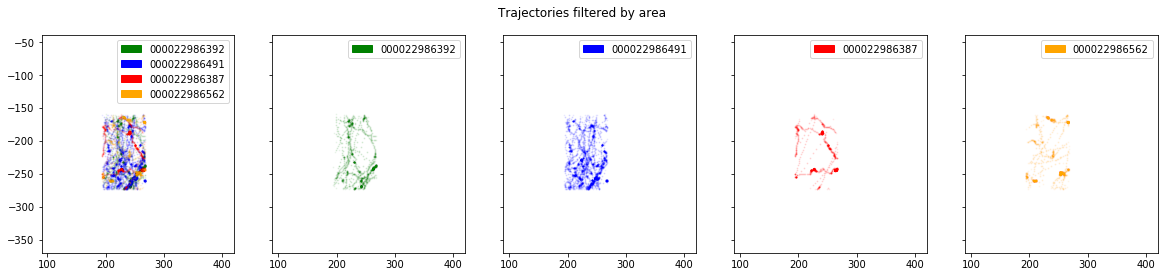

In [2]:
for file in files:

    # connect to database
    connection = sqlite3.connect( file )

    # create an animalPool, which basically contains your animals
    animalPool = AnimalPool()

    # load infos about the animals
    animalPool.loadAnimals( connection )

    # load all detection (positions) of all animals for the first hour
    animalPool.loadDetection( start = 2788230, end = 4084230  )

    # filter detection by area (in cm from the top left of the cage)
    animalPool.filterDetectionByArea( 14, 17, 27, 37 );
    
    # filter detection by area (in cm from the top left of the cage)
    #animalPool.filterDetectionSubstractionByArea( 15, 15, 30, 30 );

    # loop over all animals in this database
    for animal in animalPool.getAnimalList():

        # print RFID of animal
        print ( "Animal : " , animal.RFID )
        # number of frame in which the animal has been detected:
        numberOfFrame = len ( animal.detectionDictionnary.keys() )
        # we have 30 frames per second
        timeInSecond = numberOfFrame / 30
        # print result
        print( "Time spent in area: (in second): " , timeInSecond )

    animalPool.plotTrajectory( title="Trajectories filtered by area" , scatter=True )

In [4]:
#Returns the distance travelled

for file in files:
    # connect to database
    connection = sqlite3.connect( file )
    # create an animalPool, which basically contains your animals
    animalPool = AnimalPool()
    # load infos about the animals
    animalPool.loadAnimals( connection )       
            
    # print RFID of animal
    print ( "Animal : " , animal.RFID )
    # distance traveled by animal (in cm):            
    print( "Distance traveled in area: (in centimeter): " , animal.getDistance( ) )
    
    # load all detection (positions) of all animals for defined time
    print("You will have to enter a time window to compute the distance. Accepted formats are : number of frames, oneMinute, oneDay")
    animalPool.loadDetection( start = input('Enter starting time:'), end = input("Enter ending time:"))
    
    x1 = input("x1 coordinate (in cm):")
    y1 = input("y1 coordinate (in cm):")
    x2 = input("x2 coordinate (in cm):")
    y2 = input("y2 coordinate (in cm):")
                    
    # filter detection by area (in cm from the top left of the cage, x1, y1, x2, y2)
    animalPool.filterDetectionByArea( x1, y1, x2, y2 );
    #animalPool.filterDetectionSubstractionByArea( x1, y1, x2, y2 );

Loading animals.
Fields available in lmtanalysis:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:2 Name:B RFID:000022986392 Genotype:KO User1:None
Animal Id:3 Name:C RFID:000022986491 Genotype:KO User1:None
Animal Id:1 Name:A RFID:000022986387 Genotype:WT User1:None
Animal Id:4 Name:D RFID:000022986562 Genotype:WT User1:None
Animal :  000022986562
Compute total distance min:0 max:None 
Distance traveled in area: (in centimeter):  302.9792078203314
You will have to enter a time window to compute the distance. Accepted formats are : number of frames, oneMinute, oneDay
Enter starting time:0
Enter ending time:2592000
Animal Id:2 Name:B RFID:000022986392 Genotype:KO User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y, MASS_Z, FRONT_X, FRONT_Y, FRONT_Z, BACK_X, BACK_Y, BACK_Z,REARING,LOOK_UP,LOOK_DOWN FROM DETECTION WHERE ANIMALID=2 AND FRAMENUMBER>=0 AND FRAMENUMBER<=2592000
Animal Id:2 Name:B RFID:000022986

TypeError: '<' not supported between instances of 'float' and 'str'

## Timeline Activity

This codes allows to plot the activity (i.e. distance traveled per 10-min time bin) for each individual over the whole experiment. It saves the figure as a pdf file for each experiment. It also provides a txt file with the distance traveled in each time bin for each individual as well as the total distance traveled.

| ![](../images/timeline.jpg) | 
|:--:| 
|TimeLine example|

Code launched.
Enter time information in frame. You can also set in days, hour, minutes
valid entries: 100, 1d, 1.5d, 23.5h, 1d 2h 3m 4s 5f
Starting t : 0
Entry (in frame) : 0
Ending t : 1d
Entry (in frame) : 2592000
Enter file name to save data (.txt will be added) : OneDazActivity_9769
D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite
Experiment 9769
Loading animals.
Fields available in lmtanalysis:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:2 Name:B RFID:000022986392 Genotype:KO User1:None
Animal Id:3 Name:C RFID:000022986491 Genotype:KO User1:None
Animal Id:1 Name:A RFID:000022986387 Genotype:WT User1:None
Animal Id:4 Name:D RFID:000022986562 Genotype:WT User1:None
Animal Id:2 Name:B RFID:000022986392 Genotype:KO User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=2 AND FRAMENUMBER>=0 AND FRAMENUMBER<=2592000
Animal Id:2 Name:B RFID:000022986392 Geno

Distance bin n:1188000 value:848.035620945744
Compute total distance min:1206000 max:1224000 
Distance bin n:1206000 value:0.0
Compute total distance min:1224000 max:1242000 
Distance bin n:1224000 value:0.0
Compute total distance min:1242000 max:1260000 
Distance bin n:1242000 value:0.0
Compute total distance min:1260000 max:1278000 
Distance bin n:1260000 value:0.0
Compute total distance min:1278000 max:1296000 
Distance bin n:1278000 value:0.0
Compute total distance min:1296000 max:1314000 
Distance bin n:1296000 value:0.0
Compute total distance min:1314000 max:1332000 
Distance bin n:1314000 value:371.1556809200235
Compute total distance min:1332000 max:1350000 
Distance bin n:1332000 value:2319.8784114225878
Compute total distance min:1350000 max:1368000 
Distance bin n:1350000 value:2204.996031948271
Compute total distance min:1368000 max:1386000 
Distance bin n:1368000 value:727.755429740842
Compute total distance min:1386000 max:1404000 
Distance bin n:1386000 value:0.0
Compute

Distance bin n:324000 value:2994.173397683288
Compute total distance min:342000 max:360000 
Distance bin n:342000 value:2593.266336722033
Compute total distance min:360000 max:378000 
Distance bin n:360000 value:0.0
Compute total distance min:378000 max:396000 
Distance bin n:378000 value:0.0
Compute total distance min:396000 max:414000 
Distance bin n:396000 value:0.0
Compute total distance min:414000 max:432000 
Distance bin n:414000 value:1954.3104125795896
Compute total distance min:432000 max:450000 
Distance bin n:432000 value:3156.5749363855425
Compute total distance min:450000 max:468000 
Distance bin n:450000 value:2244.7225911876676
Compute total distance min:468000 max:486000 
Distance bin n:468000 value:2630.2423651500417
Compute total distance min:486000 max:504000 
Distance bin n:486000 value:2391.12259165585
Compute total distance min:504000 max:522000 
Distance bin n:504000 value:1674.2315927895938
Compute total distance min:522000 max:540000 
Distance bin n:522000 valu

Distance bin n:2376000 value:1792.886453584409
Compute total distance min:2394000 max:2412000 
Distance bin n:2394000 value:4880.160484609341
Compute total distance min:2412000 max:2430000 
Distance bin n:2412000 value:3419.5233301156504
Compute total distance min:2430000 max:2448000 
Distance bin n:2430000 value:3009.779105641239
Compute total distance min:2448000 max:2466000 
Distance bin n:2448000 value:2695.604598041434
Compute total distance min:2466000 max:2484000 
Distance bin n:2466000 value:3114.108195968005
Compute total distance min:2484000 max:2502000 
Distance bin n:2484000 value:2560.891139523427
Compute total distance min:2502000 max:2520000 
Distance bin n:2502000 value:2706.8091131679057
Compute total distance min:2520000 max:2538000 
Distance bin n:2520000 value:2606.5010590017664
Compute total distance min:2538000 max:2556000 
Distance bin n:2538000 value:3076.8813201102334
Compute total distance min:2556000 max:2574000 
Distance bin n:2556000 value:1934.790040722011

Distance bin n:1620000 value:2671.73430499887
Compute total distance min:1638000 max:1656000 
Distance bin n:1638000 value:2676.461677389852
Compute total distance min:1656000 max:1674000 
Distance bin n:1656000 value:2380.7698381291716
Compute total distance min:1674000 max:1692000 
Distance bin n:1674000 value:1946.2664922754536
Compute total distance min:1692000 max:1710000 
Distance bin n:1692000 value:2354.2910428889645
Compute total distance min:1710000 max:1728000 
Distance bin n:1710000 value:2325.181088007282
Compute total distance min:1728000 max:1746000 
Distance bin n:1728000 value:3022.0821100006824
Compute total distance min:1746000 max:1764000 
Distance bin n:1746000 value:2970.8279788409022
Compute total distance min:1764000 max:1782000 
Distance bin n:1764000 value:2452.9965527588115
Compute total distance min:1782000 max:1800000 
Distance bin n:1782000 value:2390.7440858201926
Compute total distance min:1800000 max:1818000 
Distance bin n:1800000 value:1845.2330903124

Distance bin n:936000 value:1111.0733790574598
Compute total distance min:954000 max:972000 
Distance bin n:954000 value:905.6744895497745
Compute total distance min:972000 max:990000 
Distance bin n:972000 value:881.4217289522882
Compute total distance min:990000 max:1008000 
Distance bin n:990000 value:1.23584424997092
Compute total distance min:1008000 max:1026000 
Distance bin n:1008000 value:790.9421030204035
Compute total distance min:1026000 max:1044000 
Distance bin n:1026000 value:284.2523761717498
Compute total distance min:1044000 max:1062000 
Distance bin n:1044000 value:1022.250320899818
Compute total distance min:1062000 max:1080000 
Distance bin n:1062000 value:0.0
Compute total distance min:1080000 max:1098000 
Distance bin n:1080000 value:1097.9907747910256
Compute total distance min:1098000 max:1116000 
Distance bin n:1098000 value:2505.1546372587995
Compute total distance min:1116000 max:1134000 
Distance bin n:1116000 value:2009.7727920710597
Compute total distance 

144
144
000022986392
000022986491
000022986387
000022986562
Saving figure...
Saving figure to  FigActivityTimeLine_Experiment 9769.pdf


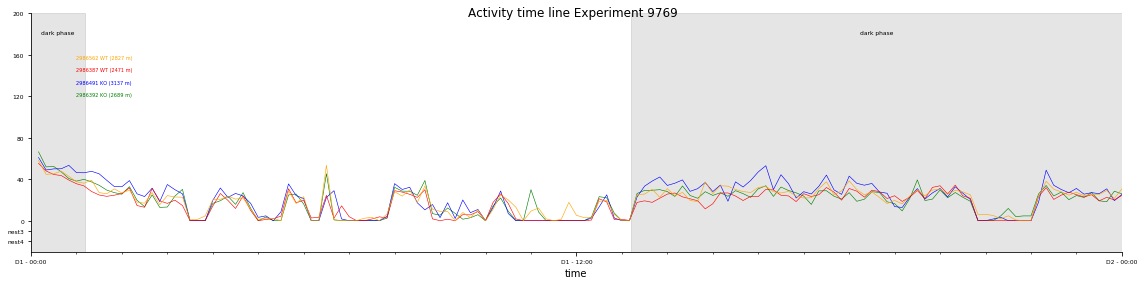

<Figure size 432x288 with 0 Axes>

In [5]:
%run ./ActivityPlot

# Plot heatmap of animal location

- This script plots heatmaps and saves them it in pdf figures.


| ![](../images/heatmap.jpg) | 
|:--:| 
|HeatMap of animal location|


Code launched.
Start : 0
Entry (in frame) : 0
End : 2592000
Entry (in frame) : 2592000
D:/live mouse tracker data/Experiment 9769/Experiment 9769.sqlite
Experiment 9769
Loading animals.
Fields available in lmtanalysis:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:2 Name:B RFID:000022986392 Genotype:KO User1:None
Animal Id:3 Name:C RFID:000022986491 Genotype:KO User1:None
Animal Id:1 Name:A RFID:000022986387 Genotype:WT User1:None
Animal Id:4 Name:D RFID:000022986562 Genotype:WT User1:None
Animal Id:2 Name:B RFID:000022986392 Genotype:KO User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=2 AND FRAMENUMBER>=0 AND FRAMENUMBER<=2592000
Animal Id:2 Name:B RFID:000022986392 Genotype:KO User1:None   1740283  detections loaded in 50.164753675460815 seconds.
Animal Id:3 Name:C RFID:000022986491 Genotype:KO User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DE

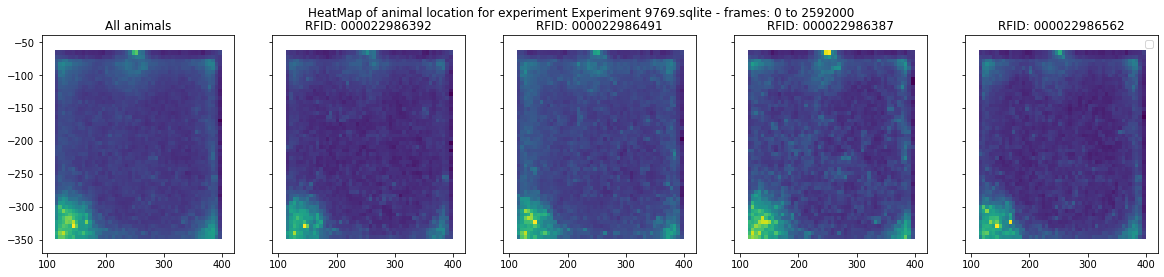

In [6]:
%run ./PlotHeatMap.py